# Preprocessing and Feature Creation

Data Processing and Feature Engineering is performed in the following, using the given variables downloaded from the Binance API, we will calculate the following:

In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=18adbc2b625d5445844073597042b655bd5e924f1fe27d4af8726cf8b1e597ac
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [4]:
# Collecting Cryptocurrency Informations
import torch
from ta.momentum import rsi
from ta.trend import macd
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from ta import add_all_ta_features
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import EMAIndicator, MACD
from ta.volume import VolumeWeightedAveragePrice

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

# Directory containing .csv files of cryptocurrency data
directory = '/kaggle/input/crypto-2021-10-01-1hour'

# Initialize an empty list to store DataFrames
dataframes = []

for filename in os.listdir(directory):
    if filename.endswith('.csv') and filename != "USDCUSDT1h.csv" and filename != "DAIUSDT1h.csv":
        ticker = filename[:-6] # Remove the '1h.csv' or '1d.csv' extension
        data = pd.read_csv(os.path.join(directory, filename), parse_dates=['time'])

        cutoff_date = pd.Timestamp('2021-10-01')

        if data['time'].iloc[0] > cutoff_date:
            print(f"Skipping {ticker}: first entry is after 2021-10-01.")
            continue  # Skip this dataset
            
        data = data[data['time'] >= cutoff_date]

        windows = [5, 10, 20]
        data["NormClose"] = (data["close"] - data["close"].mean()) / data["close"].std()
        data["DailyLogReturn"] = np.log(1 + data["close"].pct_change())

        data['volume_quote_ratio'] = data['volume'] / data['quote_volume']
        data['buy_sell_volume_ratio'] = data['buy_base_vol'] / data['volume']
        data['buy_sell_quote_ratio'] = data['buy_quote_vol'] / data['quote_volume']

        # Stochastic Oscillator
        stoch = StochasticOscillator(high = data['high'], low = data['low'], close = data['close'])
        data['stoch_k'] = stoch.stoch()
        data['stoch_d'] = stoch.stoch_signal()

        # VWAP
        vwap = VolumeWeightedAveragePrice(high = data['high'], low = data['low'],
                                         close = data['close'], volume = data['volume'])
        data['vwap'] = vwap.volume_weighted_average_price()

        for window in windows:
            # Parkinson Volatility
            data[f'parkinson_vol_{window}'] = np.sqrt(
                (1.0 / (4.0 * np.log(2.0))) *
                (np.log(data['high'] / data['low']) ** 2).rolling(window).mean()
            )

            # Garman-Klass Volatility
            data[f'garman_klass_vol_{window}'] = np.sqrt(
                (0.5 * np.log(data['high'] / data['low']) ** 2) -
                (2.0 * np.log(2.0) - 1.0) * (np.log(data['close'] / data['open']) ** 2)
            ).rolling(window).mean()

        data['avg_trade_size'] = data['volume'] / data['trades']
        data['avg_trade_quote_size'] = data['quote_volume'] / data['trades']
        data["Ticker"] = ticker
        data.set_index('time', inplace = True)
        data.drop(columns = ["open", "low", "high", "volume", "buy_base_vol", "quote_volume", "trades", "buy_quote_vol"], inplace=True)
        
        if data.empty:
            print(f"Warning: {ticker} DataFrame is empty.")
            continue

        dataframes.append(data)
        
# Concatenate all DataFrames into a single DataFrame with a hierarchical index
all_data = pd.concat(dataframes, keys=[df['Ticker'][0] for df in dataframes])

# level_0_index = 'OMUSDT'  # Replace with your actual level 0 index value

# # Filter the DataFrame for the specific level 0 index
# filtered_data = all_data.loc[level_0_index]

# # Find rows with missing/NaN values
# missing_data = filtered_data[filtered_data.isna().any(axis=1)]

# Output the rows with missing values

# Drop any rows with missing values and filter time range
all_data = all_data.dropna()
all_data = all_data.loc['2021-10-01':]

# Specify the level 1 index you want to delete
level_1_index_to_delete = pd.Timestamp('2023-06-08 23:00:00')

# Drop the specified level 1 index across all level 0 indexes
all_data = all_data.drop(level_1_index_to_delete, level=1, errors='ignore')

# Display the combined DataFrame
all_data

cuda
Skipping WBETHUSDT: first entry is after 2021-10-01.
Skipping IMXUSDT: first entry is after 2021-10-01.
Skipping RENDERUSDT: first entry is after 2021-10-01.
Skipping SUIUSDT: first entry is after 2021-10-01.
Skipping TONUSDT: first entry is after 2021-10-01.
Skipping POLUSDT: first entry is after 2021-10-01.
Skipping TIAUSDT: first entry is after 2021-10-01.
Skipping ARBUSDT: first entry is after 2021-10-01.
Skipping WLDUSDT: first entry is after 2021-10-01.
Skipping OPUSDT: first entry is after 2021-10-01.
Skipping PYTHUSDT: first entry is after 2021-10-01.
Skipping FLOKIUSDT: first entry is after 2021-10-01.
Skipping APTUSDT: first entry is after 2021-10-01.
Skipping TAOUSDT: first entry is after 2021-10-01.
Skipping LDOUSDT: first entry is after 2021-10-01.
Skipping PEPEUSDT: first entry is after 2021-10-01.
Skipping ENAUSDT: first entry is after 2021-10-01.
Skipping WIFUSDT: first entry is after 2021-10-01.
Skipping JUPUSDT: first entry is after 2021-10-01.
Skipping SEIUSDT: 

/tmp/ipykernel_30/2135173092.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_data = pd.concat(dataframes, keys=[df['Ticker'][0] for df in dataframes])


close  NormClose  DailyLogReturn  \
         time                                                      
TRXUSDT  2021-10-01 19:00:00  0.09391   0.155634        0.005017   
         2021-10-01 20:00:00  0.09379   0.151579       -0.001279   
         2021-10-01 21:00:00  0.09440   0.172191        0.006483   
         2021-10-01 22:00:00  0.09368   0.147862       -0.007656   
         2021-10-01 23:00:00  0.09481   0.186045        0.011990   
...                               ...        ...             ...   
HBARUSDT 2024-10-31 12:00:00  0.04720  -0.673584        0.000000   
         2024-10-31 13:00:00  0.04690  -0.676869       -0.006376   
         2024-10-31 14:00:00  0.04640  -0.682343       -0.010718   
         2024-10-31 15:00:00  0.04660  -0.680153        0.004301   
         2024-10-31 16:00:00  0.04640  -0.682343       -0.004301   

                              volume_quote_ratio  buy_sell_volume_ratio  \
         time                                                             
TRXUSDT  2021-10-01 19:00:00           10.660610               0.546912   
         2021-10-01 20:00:00           10.682554               0.503616   
         2021-10-01 21:00:00           10.627296               0.527739   
         2021-10-01 22:00:00           10.637673               0.528206   
         2021-10-01 23:00:00           10.614308               0.476740   
...                                          ...                    ...   
HBARUSDT 2024-10-31 12:00:00           21.210950               0.462954   
         2024-10-31 13:00:00           21.264962               0.500064   
         2024-10-31 14:00:00           21.516218               0.468662   
         2024-10-31 15:00:00           21.483317               0.527852   
         2024-10-31 16:00:00           21.536471               0.517260   

                              buy_sell_quote_ratio    stoch_k    stoch_d  \
         time                                                              
TRXUSDT  2021-10-01 19:00:00              0.546931  92.687386  90.287566   
         2021-10-01 20:00:00              0.503565  90.151515  89.091798   
         2021-10-01 21:00:00              0.527664  97.222222  93.353708   
         2021-10-01 22:00:00              0.528180  74.863388  87.412375   
         2021-10-01 23:00:00              0.476705  99.230769  90.438793   
...                                            ...        ...        ...   
HBARUSDT 2024-10-31 12:00:00              0.463167  15.000000  12.814992   
         2024-10-31 13:00:00              0.500096   5.000000   8.421053   
         2024-10-31 14:00:00              0.468641  11.538462  10.512821   
         2024-10-31 15:00:00              0.527996  20.833333  12.457265   
         2024-10-31 16:00:00              0.517390  12.500000  14.957265   

                                  vwap  parkinson_vol_5  garman_klass_vol_5  \
         time                                                                 
TRXUSDT  2021-10-01 19:00:00  0.092502         0.005954            0.006223   
         2021-10-01 20:00:00  0.092634         0.005727            0.005992   
         2021-10-01 21:00:00  0.092867         0.005516            0.005580   
         2021-10-01 22:00:00  0.093089         0.006091            0.006043   
         2021-10-01 23:00:00  0.093213         0.006414            0.005814   
...                                ...              ...                 ...   
HBARUSDT 2024-10-31 12:00:00  0.047678         0.005534            0.005605   
         2024-10-31 13:00:00  0.047587         0.005543            0.005614   
         2024-10-31 14:00:00  0.047358         0.007510            0.007403   
         2024-10-31 15:00:00  0.047237         0.007531            0.007560   
         2024-10-31 16:00:00  0.047159         0.007189            0.007164   

                              parkinson_vol_10  garman_klass_vol_10  \
         time                                                         
TRXUSDT  202

In [5]:
row_counts = all_data.groupby(level=0).size()

# Print the number of rows for each level 0 index
print(row_counts)

AAVEUSDT     27019
ADAUSDT      27019
ALGOUSDT     27019
ATOMUSDT     27019
AVAXUSDT     27019
BCHUSDT      27019
BNBUSDT      27019
BTCUSDT      27019
DOGEUSDT     27019
DOTUSDT      27019
ETCUSDT      27019
ETHUSDT      27019
FETUSDT      27019
FILUSDT      27019
FTMUSDT      27019
GRTUSDT      27019
HBARUSDT     27019
ICPUSDT      27019
INJUSDT      27019
LINKUSDT     27019
LTCUSDT      27019
MKRUSDT      27019
NEARUSDT     27019
OMUSDT       27019
RUNEUSDT     27019
SHIBUSDT     27019
SOLUSDT      27019
STXUSDT      27019
THETAUSDT    27019
TRXUSDT      27019
UNIUSDT      27019
VETUSDT      27019
XLMUSDT      27019
XRPUSDT      27019
dtype: int64


In [6]:
# Print the first row of every currency
first_rows = all_data.reset_index(level=1).groupby(level=0).first()

first_rows

time         close  NormClose  DailyLogReturn  \
AAVEUSDT  2021-10-01 19:00:00    302.200000   3.089631        0.004311   
ADAUSDT   2021-10-01 19:00:00      2.257000   3.794567        0.009795   
ALGOUSDT  2021-10-01 19:00:00      1.786500   2.882440       -0.000560   
ATOMUSDT  2021-10-01 19:00:00     37.950000   2.798339        0.006609   
AVAXUSDT  2021-10-01 19:00:00     68.450000   1.251913        0.003219   
BCHUSDT   2021-10-01 19:00:00    540.800000   1.836154       -0.000185   
BNBUSDT   2021-10-01 19:00:00    420.600000   0.333044        0.002619   
BTCUSDT   2021-10-01 19:00:00  48030.000000   0.507586        0.006388   
DOGEUSDT  2021-10-01 19:00:00      0.218300   2.256094        0.005512   
DOTUSDT   2021-10-01 19:00:00     32.120000   2.285951        0.012216   
ETCUSDT   2021-10-01 19:00:00     51.470000   2.684257        0.003893   
ETHUSDT   2021-10-01 19:00:00   3297.650000   1.052732        0.001530   
FETUSDT   2021-10-01 19:00:00      0.793200   0.227863       -0.004779   
FILUSDT   2021-10-01 19:00:00     68.890000   3.949190        0.006846   
FTMUSDT   2021-10-01 19:00:00      1.410000   1.069729       -0.002621   
GRTUSDT   2021-10-01 19:00:00      0.720700   2.225959        0.005147   
HBARUSDT  2021-10-01 19:00:00      0.367300   2.831006        0.010125   
ICPUSDT   2021-10-01 19:00:00     51.390000   3.819090        0.011350   
INJUSDT   2021-10-01 19:00:00     10.612000  -0.139001        0.001792   
LINKUSDT  2021-10-01 19:00:00     26.440000   2.289186       -0.001512   
LTCUSDT   2021-10-01 19:00:00    167.000000   2.176085        0.010232   
MKRUSDT   2021-10-01 19:00:00   2442.000000   1.115038        0.014021   
NEARUSDT  2021-10-01 19:00:00      7.916000   0.739319        0.006336   
OMUSDT    2021-10-01 19:00:00      0.239500  -0.032300       -0.002502   
RUNEUSDT  2021-10-01 19:00:00      7.864000   1.299545        0.007018   
SHIBUSDT  2021-10-01 19:00:00      0.000008  -0.838158       -0.003924   
SOLUSDT   2021-10-01 19:00:00    162.810000   1.262934       -0.002331   
STXUSDT   2021-10-01 19:00:00      1.299000   0.162013        0.000000   
THETAUSDT 2021-10-01 19:00:00      5.747000   2.536504        0.002613   
TRXUSDT   2021-10-01 19:00:00      0.093910   0.155634        0.005017   
UNIUSDT   2021-10-01 19:00:00     25.260000   3.495507        0.001981   
VETUSDT   2021-10-01 19:00:00      0.109520   2.547072        0.012865   
XLMUSDT   2021-10-01 19:00:00      0.299000   2.322317        0.002344   
XRPUSDT   2021-10-01 19:00:00      1.037800   2.532415        0.006186   

           volume_quote_ratio  buy_sell_volume_ratio  buy_sell_quote_ratio  \
AAVEUSDT             0.003311               0.619375              0.619472   
ADAUSDT              0.444293               0.588229              0.588305   
ALGOUSDT             0.557406               0.513942              0.513969   
ATOMUSDT             0.026406               0.515302              0.515285   
AVAXUSDT             0.014607               0.508468              0.508490   
BCHUSDT              0.001848               0.529221              0.529112   
BNBUSDT              0.002383               0.604418              0.604482   
BTCUSDT              0.000021               0.560800              0.560930   
DOGEUSDT             4.586494               0.541039              0.541199   
DOTUSDT              0.031236               0.593524              0.593619   
ETCUSDT              0.019455               0.596091              0.596055   
ETHUSDT              0.000303               0.562424              0.562531   
FETUSDT              1.249483               0.450585              0.450581   
FILUSDT              0.014611               0.485050              0.485050   
FTMUSDT              0.709301               0.484176              0.484629   
GRTUSDT              1.388564               0.382347              0.382685   
HBARUSDT             2.735020               0.542071              0.542098   
ICPUSDT              0.019530 

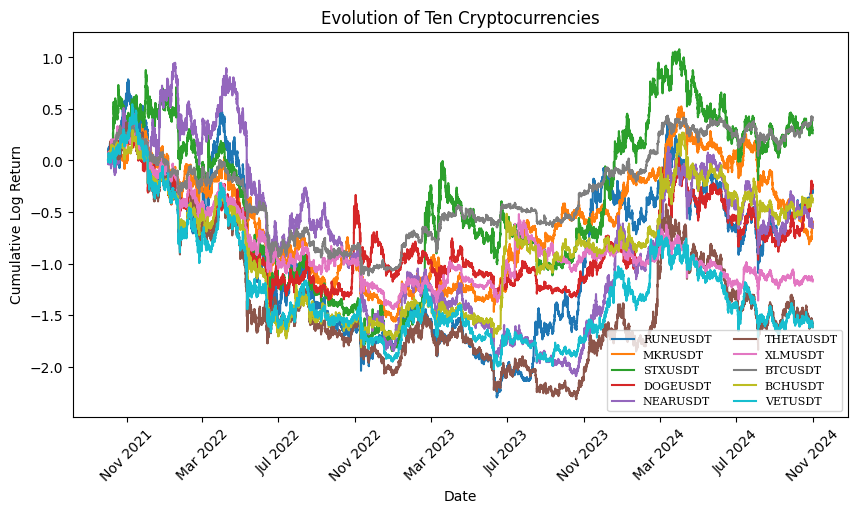

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 5))
tickers = all_data.index.get_level_values(0).unique()# Randomly select 10 tickers if you want a subset
selected_tickers = np.random.choice(tickers, size=10, replace=False)

for ticker in selected_tickers:	
    plt.plot(all_data.loc[ticker].index,              
             np.cumsum(all_data.loc[ticker]["DailyLogReturn"]),              
             label=f'{ticker}')
    
plt.title("Evolution of Ten Cryptocurrencies")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval = 4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Cumulative Log Return')
plt.legend(ncol=2, loc="lower right", prop={'size': 8, 'family': 'serif'})
plt.show()

# Correlation between Cryptocurrency

Computing the correlation between currencies to initialise the edges for the graph. Current method utilises a date range to compute correlation (2023-10-01 to 2024-10-01). Preferably, we would use fundamental information about each currency for correlation

In [10]:
df_close = all_data.copy()

# Reset the index to access the time column
df_close.reset_index(inplace=True)
df_close = df_close[["time", "Ticker", "close"]]
df_close["time"] = pd.to_datetime(df_close["time"])
df_close.set_index("time", inplace=True) 

# Sort the DataFrame by index to ensure it is monotonic
df_close.sort_index(inplace=True)
df_close["close"] = np.log(df_close["close"])

# Filter for dates in 2024
df_close_filtered = df_close.loc['2024-01-01':'2024-10-01']
df_close_filtered.reset_index(inplace=True) 

# Create a pivot table to reshape the DataFrame
df_close_filtered = pd.pivot_table(    
    df_close_filtered, 
    values="close", 
    columns="Ticker", 
    index="time")

df_close_filtered

Ticker               AAVEUSDT   ADAUSDT  ALGOUSDT  ATOMUSDT  AVAXUSDT  \
time                                                                    
2024-01-01 00:00:00  4.704291 -0.514332 -1.490322  2.370057  3.662022   
2024-01-01 01:00:00  4.713576 -0.507000 -1.488106  2.372298  3.673512   
2024-01-01 02:00:00  4.703385 -0.511659 -1.496556  2.367717  3.664587   
2024-01-01 03:00:00  4.688868 -0.518186 -1.504177  2.358020  3.650918   
2024-01-01 04:00:00  4.689236 -0.518690 -1.506430  2.354703  3.643097   
...                       ...       ...       ...       ...       ...   
2024-10-01 19:00:00  5.000450 -1.040721 -2.082647  1.491555  3.255015   
2024-10-01 20:00:00  4.986069 -1.039872 -2.085057  1.497165  3.254243   
2024-10-01 21:00:00  4.998360 -1.040438 -2.074653  1.500516  3.266522   
2024-10-01 22:00:00  4.984223 -1.049251 -2.083450  1.487496  3.256557   
2024-10-01 23:00:00  4.975423 -1.044124 -2.081043  1.490880  3.251149   

Ticker                BCHUSDT   BNBUSDT    BTCUSDT  DOGEUSDT   DOTUSDT  ...  \
time                                                                    ...   
2024-01-01 00:00:00  5.560297  5.750666  10.656676 -2.409836  2.112272  ...   
2024-01-01 01:00:00  5.562987  5.753525  10.659928 -2.406169  2.115532  ...   
2024-01-01 02:00:00  5.560682  5.739471  10.659166 -2.410170  2.110577  ...   
2024-01-01 03:00:00  5.554122  5.733988  10.653263 -2.416762  2.097772  ...   
2024-01-01 04:00:00  5.549854  5.733988  10.654903 -2.417996  2.096790  ...   
...                       ...       ...        ...       ...       ...  ...   
2024-10-01 19:00:00  5.768633  6.307734  11.030946 -2.244411  1.427196  ...   
2024-10-01 20:00:00  5.760478  6.298214  11.015493 -2.239329  1.431507  ...   
2024-10-01 21:00:00  5.768633  6.309736  11.020954 -2.229056  1.435085  ...   
2024-10-01 22:00:00  5.761108  6.305728  11.014818 -2.238766  1.424794  ...   
2024-10-01 23:00:00  5.761422  6.304997  11.015440 -2.236329  1.424072  ...   

Ticker               RUNEUSDT   SHIBUSDT   SOLUSDT   STXUSDT  THETAUSDT  \
time                                                                      
2024-01-01 00:00:00  1.645191 -11.475630  4.624581  0.398709   0.248421   
2024-01-01 01:00:00  1.649043 -11.471784  4.645544  0.412242   0.238229   
2024-01-01 02:00:00  1.643646 -11.474667  4.641406  0.416867   0.231905   
2024-01-01 03:00:00  1.633740 -11.483367  4.635408  0.392380   0.217528   
2024-01-01 04:00:00  1.627474 -11.484338  4.631033  0.388251   0.216723   
...                       ...        ...       ...       ...        ...   
2024-10-01 19:00:00  1.539230 -11.032972  4.979626  0.520578   0.269263   
2024-10-01 20:00:00  1.523662 -11.027418  4.977285  0.528862   0.272315   
2024-10-01 21:00:00  1.533636 -11.015793  4.985386  0.537662   0.277632   
2024-10-01 22:00:00  1.521917 -11.023732  4.974524  0.528862   0.267734   
2024-10-01 23:00:00  1.520607 -11.017010  4.977630  0.536493   0.264669   

Ticker                TRXUSDT   UNIUSDT   VETUSDT   XLMUSDT   XRPUSDT  
time                                                                   
2024-01-01 00:00:00 -2.222665  1.989654 -3.363035 -2.046394 -0.484184  
2024-01-01 01:00:00 -2.223774  1.994972 -3.358713 -2.042531 -0.480458  
2024-01-01 02:00:00 -2.227385  1.988833 -3.359864 -2.047943 -0.485483  
2024-01-01 03:00:00 -2.233899  1.976578 -3.373485 -2.052605 -0.489390  
2024-01-01 04:00:00 -2.239235  1.977686 -3.377579 -2.058072 -0.491677  
...                       ...       ...       ...       ...       ...  
2024-10-01 19:00:00 -1.872102  1.943049 -3.780556 -2.364460 -0.493477  
2024-10-01 20:00:00 -1.872753  1.937590 -3.776182 -2.364460 -0.499886  
2024-10-01 21:00:00 -1.871452  1.943049 -3.776182 -2.362335 -0.507996  
2024-10-01 22:00:00 -1.874055  1.930651 -3.788037 -2.369794 -0.519026  
2024-10-01 23:00:00 -1.873403  1.927019 -3.786272 -2.365525 -0.516341  

[6600 rows x 34 columns]

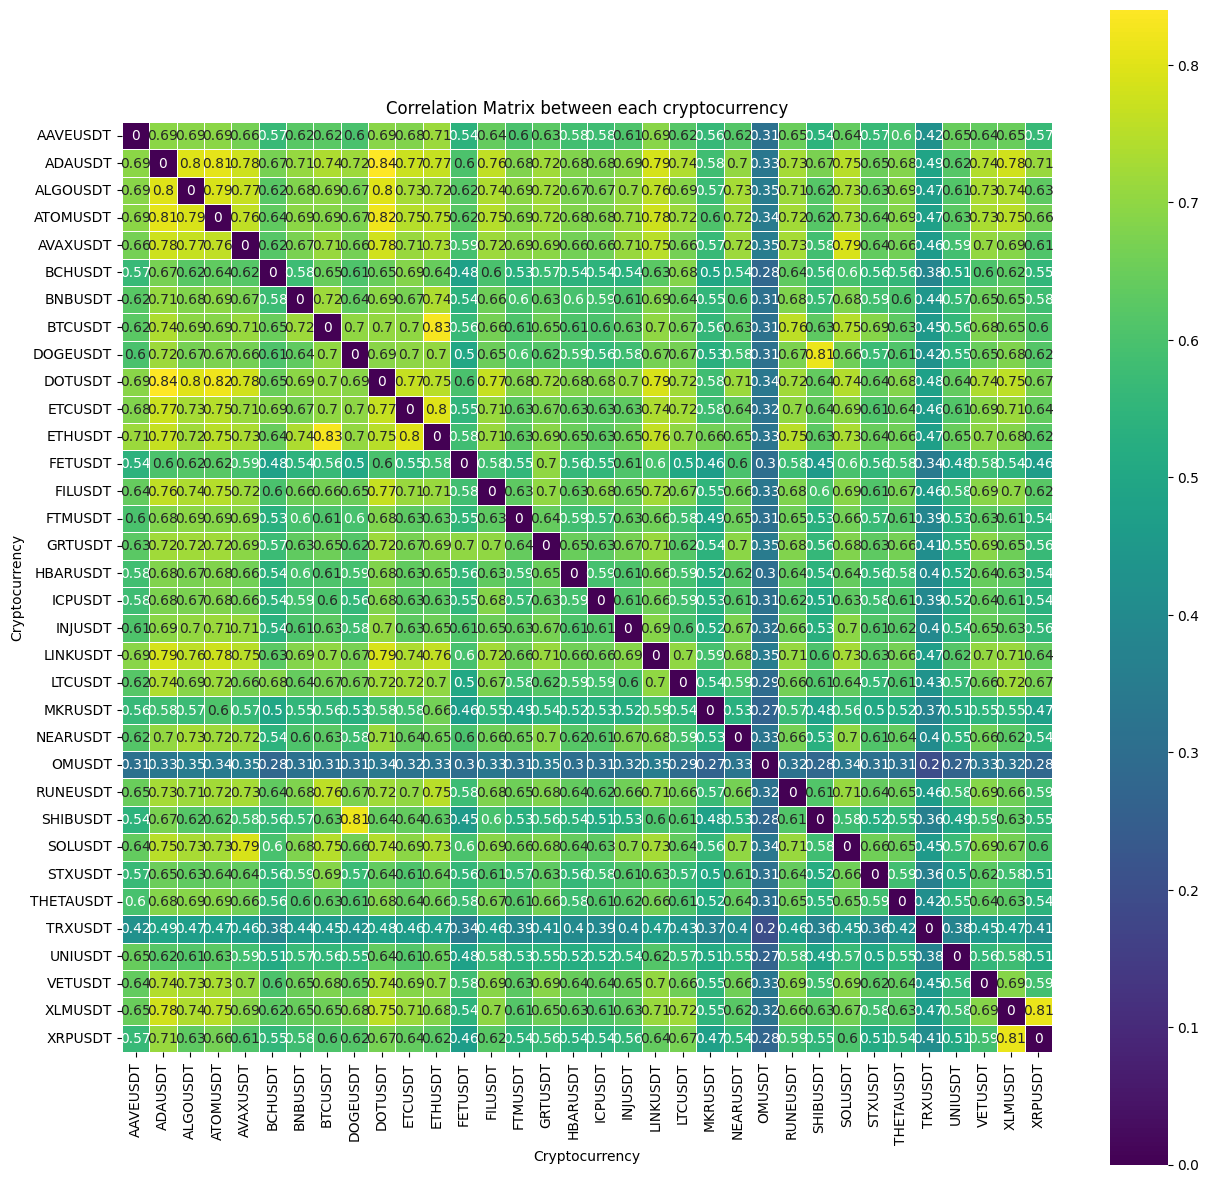

In [11]:
import seaborn as sns

correlation_matrix = df_close_filtered.diff().corr()
correlation_matrix = (correlation_matrix - (correlation_matrix == 1)) # Drop Self-Correlation

plt.figure(figsize=(15, 15))

sns.heatmap(correlation_matrix,            
            linewidths=.5,            
            annot=True,            
            square=True,            
            cmap="viridis")

plt.xlabel("Cryptocurrency")
plt.ylabel("Cryptocurrency")
plt.title("Correlation Matrix between each cryptocurrency")
plt.show()

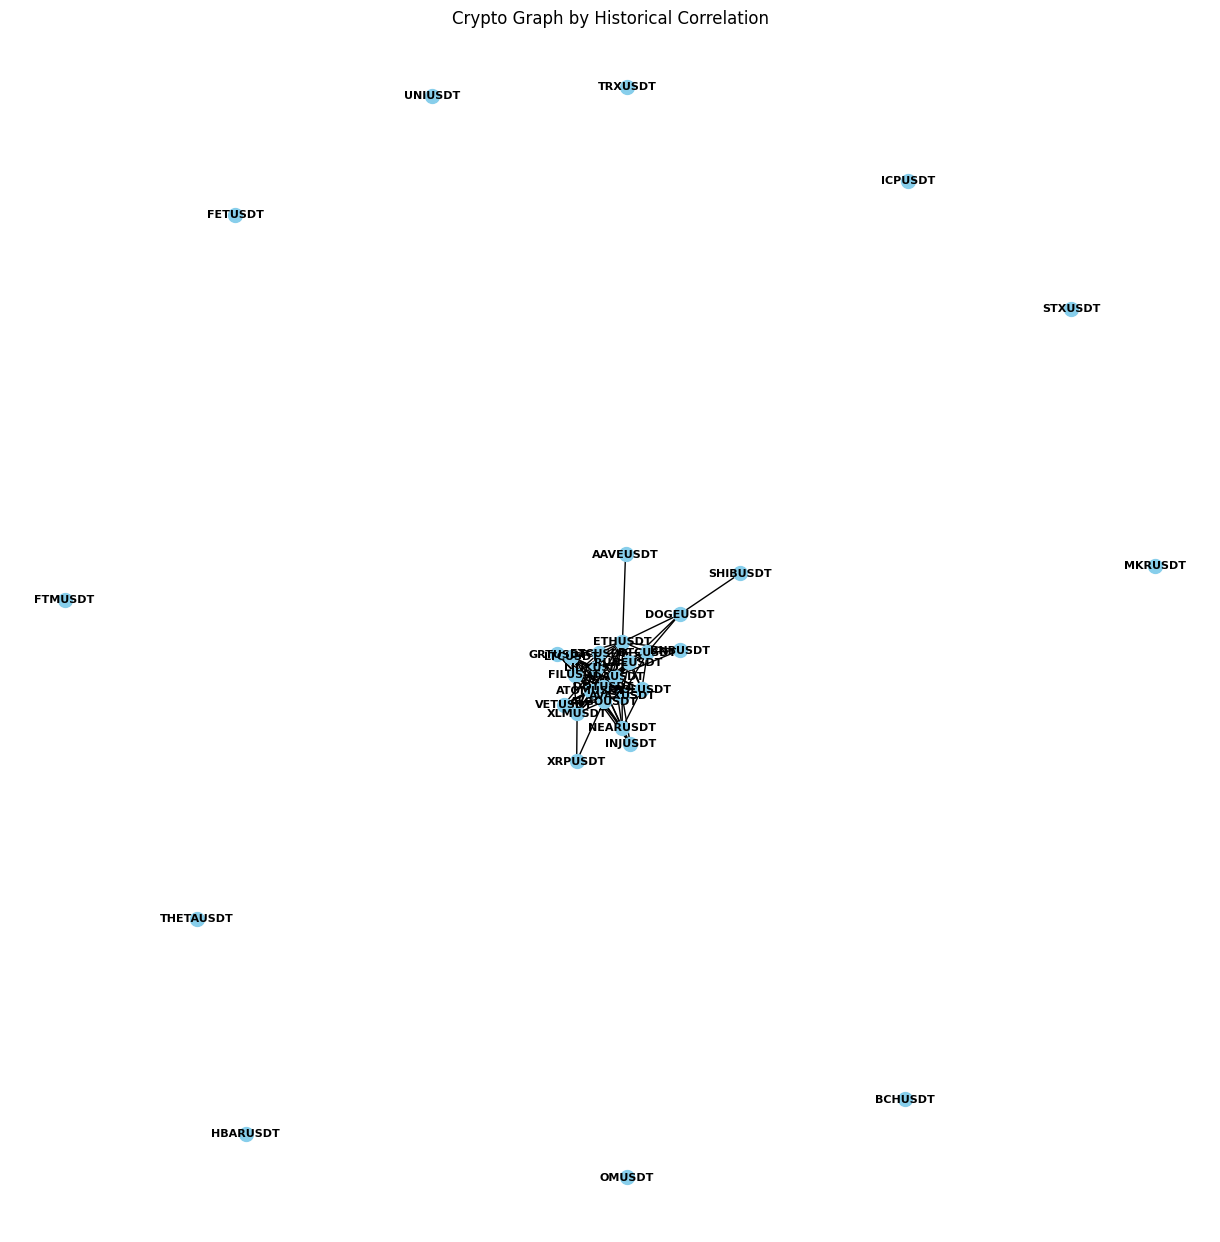

In [12]:
import networkx as nx
correlation_matrix_np = correlation_matrix.to_numpy()
adj_correlation_matrix = (correlation_matrix_np * (abs(correlation_matrix_np) > .7).astype(int)) # Threshold to form edge (0.7)
correlation_matrix_graph = nx.from_numpy_array(adj_correlation_matrix)
correlation_matrix_graph = nx.relabel_nodes(correlation_matrix_graph, dict(enumerate(correlation_matrix.index)))

plt.figure(figsize=(12, 12))

nx.draw(correlation_matrix_graph, 
        with_labels=True, 
        node_size=100, 
        node_color='skyblue', 
        font_size=8, 
        font_weight='bold', 
        font_color='black', 
        pos=nx.spring_layout(correlation_matrix_graph))

plt.title('Crypto Graph by Historical Correlation')
plt.show()

In [13]:
adj_correlation_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.7999901 , ..., 0.74281102, 0.77976407,
        0.7109679 ],
       [0.        , 0.7999901 , 0.        , ..., 0.73342326, 0.73544444,
        0.        ],
       ...,
       [0.        , 0.74281102, 0.73342326, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.77976407, 0.73544444, ..., 0.        , 0.        ,
        0.81094014],
       [0.        , 0.7109679 , 0.        , ..., 0.        , 0.81094014,
        0.        ]])

# Building PyTorch Geometric Dataset

In [14]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.8 MB/s eta 0:00:00a 0:00:01


In [16]:
import torch
from torch_geometric.data import Data

nodes_nb = len(adj_correlation_matrix)
 
x = torch.tensor(
	all_data.drop(columns=["Ticker", "close"]).to_numpy().reshape((nodes_nb, -1, all_data.shape[1] - 2)), dtype=torch.float32).to(device)  # shape (nodes_nb, timestamps_nb, features_nb) Note: This won't work if they are not integers
x = x.transpose(1, 2)  # shape (nodes_nb, features_nb, timestamps_nb)

close_prices = torch.tensor(
		all_data[["close"]].to_numpy().reshape((nodes_nb, -1)), dtype=torch.float32
	).to(device)

edge_nb = np.count_nonzero(adj_correlation_matrix)
edge_index, edge_weight = torch.zeros((2, edge_nb), dtype=torch.long).to(device), torch.zeros((edge_nb,), dtype=torch.float32).to(device)
count = 0
for i in range(nodes_nb):
		for j in range(nodes_nb):
			if (weight := adj_correlation_matrix[i, j]) != 0:
				edge_index[0, count], edge_index[1, count] = i, j
				edge_weight[count] = weight
				count += 1

x.shape, edge_index.shape, edge_weight.shape

(torch.Size([34, 16, 27019]), torch.Size([2, 208]), torch.Size([208]))

In [17]:
past_window, future_window = 25, 1
timestamps = [
			Data(
				x = x[:, :, idx:idx + past_window],
				edge_index = edge_index,
				edge_weight = edge_weight,
				close_price = close_prices[:, idx:idx + past_window],
				y = x[:, 0, idx + past_window:idx + past_window + future_window],
				close_price_y=close_prices[:, idx + past_window:idx + past_window + future_window],
			).to(device) for idx in range(x.shape[2] - past_window - future_window)
		]

print(timestamps[-1])

Data(x=[34, 16, 25], edge_index=[2, 208], y=[34, 1], edge_weight=[208], close_price=[34, 25], close_price_y=[34, 1])


# Model Definition

Baseline Graph Convolutional Network Models used for comparing our modified MTGNN. We researched various other GCNs that also capture temporal and spatial dynamics in a dataset. The following models and the research papers they are from are included below.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv

class GCN(nn.Module):
	"""
	Simple two layers GCN model.
	"""
	def __init__(self, in_channels: int, layer_sizes: list[int] = None, bias: bool = True, improved: bool = False):
		super(GCN, self).__init__()
		layer_sizes = layer_sizes or [32, 32]
		self.convs = nn.ModuleList([
		   GCNConv(in_channels, layer_sizes[0], bias=bias, improved=improved),
		] + [
		   GCNConv(layer_sizes[i], layer_sizes[i + 1], bias=bias, improved=improved) for i in
		   range(len(layer_sizes) - 1)
   		])

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The hidden state of the GCN h_t (Nodes_nb, Hidden_size)
		"""
		for conv in self.convs[:-1]:
			x = F.leaky_relu(conv(x, edge_index, edge_weight))
		return self.convs[-1](x, edge_index, edge_weight)
        
class GAT(nn.Module):
	"""
	Simple two layers GAT model.
	"""
	def __init__(self, in_channels: int, layer_sizes: list[int] = None, bias: bool = True):
		super(GAT, self).__init__()
		layer_sizes = layer_sizes or [32, 32]
		self.convs = nn.ModuleList([
		   GATv2Conv(in_channels, layer_sizes[0], bias=bias, edge_dim=1),
		] + [
		   GATv2Conv(layer_sizes[i], layer_sizes[i + 1], bias=bias, edge_dim=1) for i in
		   range(len(layer_sizes) - 1)
   		])

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The hidden state of the GCN h_t (Nodes_nb, Hidden_size)
		"""
		for conv in self.convs[:-1]:
			x = F.leaky_relu(conv(x, edge_index, edge_weight))
		return self.convs[-1](x, edge_index, edge_weight)

class TGCNCell(nn.Module):
	"""
	T-GCN Cell for one timestep, from https://arxiv.org/pdf/1811.05320.
	"""
	def __init__(self, in_channels: int, hidden_size: int, use_gat: bool = True):
		super(TGCNCell, self).__init__()
		if use_gat:
			self.gcn = GAT(in_channels, [hidden_size, hidden_size]).to(device)
		else:
			self.gcn = GCN(in_channels, [hidden_size, hidden_size]).to(device)
		self.lin_u = nn.Linear(2 * hidden_size + in_channels, hidden_size)
		self.lin_r = nn.Linear(2 * hidden_size + in_channels, hidden_size)
		self.lin_c = nn.Linear(2 * hidden_size + in_channels, hidden_size)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor, h: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
		"""
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:param h: The hidden state of the GRU h_{t-1} (Nodes_nb, Hidden_size)
		:return: The hidden state of the GRU h_t (Nodes_nb, Hidden_size)
		"""
		gcn_out = F.sigmoid(self.gcn(x, edge_index, edge_weight))  # f(A,X_t), Eq. 2
		u = F.sigmoid(self.lin_u(torch.cat([x, gcn_out, h], dim=-1)))  # u_t, Eq. 3
		r = F.sigmoid(self.lin_r(torch.cat([x, gcn_out, h], dim=-1)))  # r_t,  Eq. 4
		c = F.tanh(self.lin_c(torch.cat([x, gcn_out, r * h], dim=-1)))  # c_t, Eq. 5

		return u * h + (1 - u) * c  # h_t, Eq. 6

class TGCN(nn.Module):
	"""
	T-GCN model from https://arxiv.org/pdf/1811.05320.
	"""
	def __init__(self, in_channels: int, out_channels: int, hidden_size: int, layers_nb: int = 2, output_activation: nn.Module = None, use_gat: bool = True):
		super(TGCN, self).__init__()
		self.hidden_size = hidden_size
		self.layers_nb = max(1, layers_nb)
		self.cells = nn.ModuleList(
			[TGCNCell(in_channels, hidden_size, use_gat=use_gat)] + [TGCNCell(hidden_size, hidden_size, use_gat=use_gat) for _ in range(self.layers_nb - 1)]
		)
		self.out = nn.Sequential(
			nn.Linear(hidden_size, out_channels),
			output_activation if output_activation is not None else nn.Identity(),
		)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb, SeqLength)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The output of the model (Nodes_nb, OutFeatures_nb)
		"""
		h_prev = [
			torch.zeros(x.shape[0], self.hidden_size).to(device) for _ in range(self.layers_nb)
		]
		for t in range(x.shape[-1]):
			h = x[:, :, t]  # h is the output of the previous GRU layer (the input features for the first layer)
			for i, cell in enumerate(self.cells):
				h = cell(h, edge_index, edge_weight, h_prev[i])
				h_prev[i] = h
		return self.out(h_prev[-1])

class A3TGCN(nn.Module):
	"""
	A3T-GCN model from https://arxiv.org/pdf/2006.11583.
	"""
	def __init__(self, in_channels: int, out_channels: int, hidden_size: int, layers_nb: int = 2, output_activation: nn.Module = None, use_gat: bool = True):
		super(A3TGCN, self).__init__()
		self.hidden_size = hidden_size
		self.layers_nb = max(1, layers_nb)
		self.cells = nn.ModuleList(
			[TGCNCell(in_channels, hidden_size, use_gat=use_gat)] + [TGCNCell(hidden_size, hidden_size, use_gat=use_gat) for _ in range(self.layers_nb - 1)]
		)
		self.attention = nn.Sequential(
			nn.Linear(hidden_size, 1),
			nn.Softmax(dim=1),
		)
		nn.init.uniform_(self.attention[0].weight)
		self.out = nn.Sequential(
			nn.Linear(hidden_size, out_channels),
			output_activation if output_activation is not None else nn.Identity(),
		)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb, SeqLength)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The output of the model (Nodes_nb, OutFeatures_nb)
		"""
		h_prev = [
			torch.zeros(x.shape[0], self.hidden_size).to(device) for _ in range(self.layers_nb)
		]
		h_final = torch.zeros(x.shape[0], x.shape[-1], self.hidden_size).to(device)
		for t in range(x.shape[-1]):
			h = x[:, :, t]  # h is the output of the previous GRU layer (the input features for the first layer)
			for i, cell in enumerate(self.cells):
				h = cell(h, edge_index, edge_weight, h_prev[i])
				h_prev[i] = h
			h_final[:, t, :] = h
		return self.out(F.leaky_relu(torch.sum(F.leaky_relu(h_final) * self.attention(h_final), dim=1)))


class DCGRUCell(nn.Module):
	"""
	DCRNN Cell for one timestep, from https://arxiv.org/pdf/1707.01926.
	"""
	def __init__(self, in_channels: int, hidden_size: int, use_gat: bool = True):
		super(DCGRUCell, self).__init__()
		if use_gat:
			self.gcn_r = GAT(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
			self.gcn_u = GAT(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
			self.gcn_c = GAT(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
		else:
			self.gcn_r = GCN(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
			self.gcn_u = GCN(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
			self.gcn_c = GCN(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor, h: torch.tensor) -> torch.tensor:
		"""
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:param h: The hidden state of the GRU h_{t-1} (Nodes_nb, Hidden_size)
		:return: The hidden state of the GRU h_t (Nodes_nb, Hidden_size)
		"""
		x_h = torch.cat([x, h], dim=-1)
		r = F.sigmoid(self.gcn_r(x_h, edge_index, edge_weight))
		u = F.sigmoid(self.gcn_u(x_h, edge_index, edge_weight))
		c = F.tanh(self.gcn_c(torch.cat([x, r * h], dim=-1), edge_index, edge_weight))
		return u * h + (1 - u) * c

class DCGNN(nn.Module):
	"""
	DCGNN model from https://arxiv.org/pdf/1707.01926.
	"""
	def __init__(self, in_channels: int, out_channels: int, hidden_size: int, layers_nb: int = 2, output_activation: nn.Module = None, use_gat: bool = True):
		super(DCGNN, self).__init__()
		self.hidden_size = hidden_size
		self.layers_nb = max(1, layers_nb)
		self.cells = nn.ModuleList(
			[DCGRUCell(in_channels, hidden_size, use_gat=use_gat)] + [DCGRUCell(hidden_size, hidden_size, use_gat=use_gat) for _ in range(self.layers_nb - 1)]
		)
		self.out = nn.Sequential(
			nn.Linear(hidden_size, out_channels),
			output_activation if output_activation is not None else nn.Identity(),
		)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb, SeqLength)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The output of the model (Nodes_nb, OutFeatures_nb)
		"""
		h_prev = [
			torch.zeros(x.shape[0], self.hidden_size).to(device) for _ in range(self.layers_nb)
		]
		for t in range(x.shape[-1]):
			h = x[:, :, t]  # h is the output of the previous GRU layer (the input features for the first layer)
			for i, cell in enumerate(self.cells):
				h = cell(h, edge_index, edge_weight, h_prev[i])
				h_prev[i] = h
		return self.out(h_prev[-1])

# Training and Testing

In [14]:
torch.cuda.empty_cache()

In [22]:
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
torch.cuda.empty_cache()

train_part = .9 # Split Data by so that first 90% is for training, and last 10% for testing
batch_size = 16

train_dataset, test_dataset = timestamps[:int(train_part * len(timestamps))], timestamps[int(train_part * len(timestamps)):]
print(f"Train dataset: {len(train_dataset)}, Test dataset: {len(test_dataset)}")
train_dataloader, test_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True), DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)

Train dataset: 24293, Test dataset: 2700


In [44]:
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.data import DataLoader
from datetime import datetime
from tqdm import trange
        
def test_iteration(model: nn.Module, criterion: nn.Module, test_dataloader: DataLoader, epoch: int, writer: SummaryWriter) -> None:
    """
    Test iteration
    :param model: Model to test
    :param criterion: Loss function to use
    :param test_dataloader: Test data loader
    :param epoch: Current epoch
    :param writer: Tensorboard writer
    """
    model.eval()
    for idx, data in enumerate(test_dataloader):
        data = data.to(device) 
        out = model(data.x, data.edge_index, data.edge_weight).to(device) 
        loss = criterion(out, data.y)
        writer.add_scalar("Loss/Test Loss", loss.item(), epoch * len(test_dataloader) + idx)

def train_iteration(model: nn.Module, optimizer: optim.Optimizer, pbar: trange, criterion: nn.Module, train_dataloader: DataLoader, epoch: int, writer: SummaryWriter) -> None:
    """
    Train iteration
    :param model: Model to train
    :param optimizer: Optimizer to use (Adam, ...)
    :param pbar: tqdm progress bar
    :param criterion: Loss function to use
    :param train_dataloader: Train data loader
    :param epoch: Current epoch
    :param writer: Tensorboard writer
    :param measure_acc: Whether to measure accuracy or not (for classification tasks)
    """
    model.train()
    total_loss = 0.0
    num_batches = len(train_dataloader)
    
    for idx, data in enumerate(train_dataloader):
        data = data.to(device) 
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_weight)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({"Batch": f"{(idx + 1) / len(train_dataloader) * 100:.1f}%"})
        writer.add_scalar("Loss/Train Loss", loss.item(), epoch * len(train_dataloader) + idx)
        
    average_loss = total_loss / num_batches
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {average_loss:.4f}')

def train(model: nn.Module, optimizer: optim.Optimizer, criterion: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, num_epochs: int, task_title: str = "") -> None:
    """
    Train function for a regression / classification model
    :param model: Model to train
    :param optimizer: Optimizer to use (Adam, ...)
    :param criterion: Loss function to use
    :param train_dataloader: Train data loader
    :param test_dataloader: Test data loader
    :param num_epochs: Number of epochs to train on the train dataset
    :param task_title: Title of the tensorboard run
    """
    writer = SummaryWriter(f'runs/{task_title}_{datetime.now().strftime("%d_%m_%Hh%M")}_{model.__class__.__name__}')
    for epoch in (pbar := trange(num_epochs, desc="Epochs")):
        train_iteration(model, optimizer, pbar, criterion, train_dataloader, epoch, writer)
        test_iteration(model, criterion, test_dataloader, epoch, writer)

# Training

In [45]:
in_channels, out_channels, hidden_size, layers_nb = timestamps[0].x.shape[-2], 1, 16, 2
lr, weight_decay, num_epochs = 0.001, 1e-5, 16

tgcn_no_gat_model = TGCN(in_channels, out_channels, hidden_size, layers_nb, use_gat = False).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(tgcn_no_gat_model.parameters(), lr = lr, weight_decay = weight_decay)

tgcn_no_gat_model

TGCN(
  (cells): ModuleList(
    (0-1): 2 x TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0-1): 2 x GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Identity()
  )
)

In [46]:
train(tgcn_no_gat_model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs, "PriceForecasting_TGCN")
torch.save(tgcn_no_gat_model.state_dict(), 'tgcn_no_gat_model_epoch_16.pth')

Epochs:   0%|          | 0/16 [04:17<?, ?it/s, Batch=100.0%]

Epoch 1/16, Average Training Loss: 0.2572


Epochs:   6%|▋         | 1/16 [08:35<1:04:29, 257.95s/it, Batch=100.0%]

Epoch 2/16, Average Training Loss: 0.0811


Epochs:  12%|█▎        | 2/16 [12:55<1:00:12, 258.02s/it, Batch=100.0%]

Epoch 3/16, Average Training Loss: 0.0595


Epochs:  19%|█▉        | 3/16 [17:13<56:06, 258.95s/it, Batch=100.0%]  

Epoch 4/16, Average Training Loss: 0.0591


Epochs:  25%|██▌       | 4/16 [21:31<51:44, 258.75s/it, Batch=100.0%]

Epoch 5/16, Average Training Loss: 0.0595


Epochs:  31%|███▏      | 5/16 [25:48<47:22, 258.37s/it, Batch=100.0%]

Epoch 6/16, Average Training Loss: 0.0462


Epochs:  38%|███▊      | 6/16 [30:05<42:58, 257.81s/it, Batch=100.0%]

Epoch 7/16, Average Training Loss: 0.0446


Epochs:  44%|████▍     | 7/16 [34:22<38:38, 257.59s/it, Batch=100.0%]

Epoch 8/16, Average Training Loss: 0.0922


Epochs:  50%|█████     | 8/16 [38:39<34:19, 257.45s/it, Batch=100.0%]

Epoch 9/16, Average Training Loss: 0.0714


Epochs:  56%|█████▋    | 9/16 [42:58<30:01, 257.33s/it, Batch=100.0%]

Epoch 10/16, Average Training Loss: 0.0566


Epochs:  62%|██████▎   | 10/16 [47:15<25:46, 257.67s/it, Batch=100.0%]

Epoch 11/16, Average Training Loss: 0.0580


Epochs:  69%|██████▉   | 11/16 [51:32<21:28, 257.72s/it, Batch=100.0%]

Epoch 12/16, Average Training Loss: 0.0451


Epochs:  75%|███████▌  | 12/16 [55:50<17:09, 257.47s/it, Batch=100.0%]

Epoch 13/16, Average Training Loss: 0.0423


Epochs:  81%|████████▏ | 13/16 [1:00:07<12:52, 257.51s/it, Batch=100.0%]

Epoch 14/16, Average Training Loss: 0.0415


Epochs:  88%|████████▊ | 14/16 [1:04:24<08:35, 257.51s/it, Batch=100.0%]

Epoch 15/16, Average Training Loss: 0.0515


Epochs:  94%|█████████▍| 15/16 [1:08:40<04:17, 257.15s/it, Batch=100.0%]

Epoch 16/16, Average Training Loss: 0.0526


Epochs: 100%|██████████| 16/16 [1:08:41<00:00, 257.60s/it, Batch=100.0%]


In [47]:
torch.save(tgcn_no_gat_model.state_dict(), 'tgcn_no_gat_model_epoch_16.pth')

In [30]:
in_channels, out_channels, hidden_size, layers_nb = timestamps[0].x.shape[-2], 1, 16, 2
a3tgcn_no_gat_model = A3TGCN(in_channels, out_channels, hidden_size, layers_nb, use_gat = False).to(device)

lr, weight_decay, num_epochs = 0.001, 1e-5, 16

criterion = nn.MSELoss()
optimizer_a3tgcn = optim.Adam(a3tgcn_no_gat_model.parameters(), lr=lr, weight_decay=weight_decay)
a3tgcn_no_gat_model

A3TGCN(
  (cells): ModuleList(
    (0-1): 2 x TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0-1): 2 x GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (attention): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Softmax(dim=1)
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Identity()
  )
)

In [31]:
train(a3tgcn_no_gat_model, optimizer_a3tgcn, criterion, train_dataloader, test_dataloader, num_epochs, "PriceForecasting_A3TGCN")
torch.save(a3tgcn_no_gat_model.state_dict(), 'a3tgcn_no_gat_model_epoch_16.pth')

Epochs:   0%|          | 0/16 [04:28<?, ?it/s, Batch=100.0%]

Epoch 1/16, Average Training Loss: 0.3301


Epochs:   6%|▋         | 1/16 [04:29<1:07:13, 268.87s/it, Batch=0.1%]  

Epoch 1/16, Average Testing Loss: 0.1853


Epochs:   6%|▋         | 1/16 [08:59<1:07:13, 268.87s/it, Batch=100.0%]

Epoch 2/16, Average Training Loss: 0.0861


Epochs:  12%|█▎        | 2/16 [09:00<1:03:05, 270.37s/it, Batch=0.1%]  

Epoch 2/16, Average Testing Loss: 0.1564


Epochs:  12%|█▎        | 2/16 [13:30<1:03:05, 270.37s/it, Batch=100.0%]

Epoch 3/16, Average Training Loss: 0.0731


Epochs:  19%|█▉        | 3/16 [13:31<58:40, 270.78s/it, Batch=0.1%]    

Epoch 3/16, Average Testing Loss: 0.1039


Epochs:  19%|█▉        | 3/16 [18:03<58:40, 270.78s/it, Batch=100.0%]

Epoch 4/16, Average Training Loss: 0.0930


Epochs:  25%|██▌       | 4/16 [18:04<54:17, 271.45s/it, Batch=0.1%]  

Epoch 4/16, Average Testing Loss: 0.1041


Epochs:  25%|██▌       | 4/16 [22:32<54:17, 271.45s/it, Batch=100.0%]

Epoch 5/16, Average Training Loss: 0.0694


Epochs:  31%|███▏      | 5/16 [22:33<49:38, 270.74s/it, Batch=0.1%]  

Epoch 5/16, Average Testing Loss: 0.0894


Epochs:  31%|███▏      | 5/16 [27:03<49:38, 270.74s/it, Batch=100.0%]

Epoch 6/16, Average Training Loss: 0.0559


Epochs:  38%|███▊      | 6/16 [27:03<45:05, 270.57s/it, Batch=0.1%]  

Epoch 6/16, Average Testing Loss: 0.1131


Epochs:  38%|███▊      | 6/16 [31:31<45:05, 270.57s/it, Batch=100.0%]

Epoch 7/16, Average Training Loss: 0.0528


Epochs:  44%|████▍     | 7/16 [31:31<40:27, 269.74s/it, Batch=0.1%]  

Epoch 7/16, Average Testing Loss: 0.0809


Epochs:  44%|████▍     | 7/16 [35:59<40:27, 269.74s/it, Batch=100.0%]

Epoch 8/16, Average Training Loss: 0.0628


Epochs:  50%|█████     | 8/16 [36:00<35:55, 269.38s/it, Batch=0.1%]  

Epoch 8/16, Average Testing Loss: 0.1142


Epochs:  50%|█████     | 8/16 [40:27<35:55, 269.38s/it, Batch=100.0%]

Epoch 9/16, Average Training Loss: 0.0558


Epochs:  56%|█████▋    | 9/16 [40:28<31:22, 268.92s/it, Batch=0.1%]  

Epoch 9/16, Average Testing Loss: 0.1170


Epochs:  56%|█████▋    | 9/16 [44:57<31:22, 268.92s/it, Batch=100.0%]

Epoch 10/16, Average Training Loss: 0.0706


Epochs:  62%|██████▎   | 10/16 [44:58<26:55, 269.28s/it, Batch=0.1%]  

Epoch 10/16, Average Testing Loss: 0.1195


Epochs:  62%|██████▎   | 10/16 [49:27<26:55, 269.28s/it, Batch=100.0%]

Epoch 11/16, Average Training Loss: 0.0506


Epochs:  69%|██████▉   | 11/16 [49:28<22:27, 269.57s/it, Batch=0.1%]  

Epoch 11/16, Average Testing Loss: 0.0965


Epochs:  69%|██████▉   | 11/16 [53:55<22:27, 269.57s/it, Batch=100.0%]

Epoch 12/16, Average Training Loss: 0.0726


Epochs:  75%|███████▌  | 12/16 [53:56<17:56, 269.08s/it, Batch=0.1%]  

Epoch 12/16, Average Testing Loss: 0.1086


Epochs:  75%|███████▌  | 12/16 [58:21<17:56, 269.08s/it, Batch=100.0%]

Epoch 13/16, Average Training Loss: 0.0710


Epochs:  81%|████████▏ | 13/16 [58:22<13:24, 268.01s/it, Batch=0.1%]  

Epoch 13/16, Average Testing Loss: 0.1575


Epochs:  81%|████████▏ | 13/16 [1:02:48<13:24, 268.01s/it, Batch=100.0%]

Epoch 14/16, Average Training Loss: 0.0601


Epochs:  88%|████████▊ | 14/16 [1:02:49<08:55, 267.79s/it, Batch=0.1%]  

Epoch 14/16, Average Testing Loss: 0.1283


Epochs:  88%|████████▊ | 14/16 [1:07:14<08:55, 267.79s/it, Batch=100.0%]

Epoch 15/16, Average Training Loss: 0.0770


Epochs:  94%|█████████▍| 15/16 [1:07:15<04:27, 267.14s/it, Batch=0.1%]  

Epoch 15/16, Average Testing Loss: 0.1161


Epochs:  94%|█████████▍| 15/16 [1:11:42<04:27, 267.14s/it, Batch=100.0%]

Epoch 16/16, Average Training Loss: 0.0610


Epochs: 100%|██████████| 16/16 [1:11:42<00:00, 268.92s/it, Batch=100.0%]

Epoch 16/16, Average Testing Loss: 0.1379


In [36]:
in_channels, out_channels, hidden_size, layers_nb = timestamps[0].x.shape[-2], 1, 16, 2
dcgnn_no_gat_model = DCGNN(in_channels, out_channels, hidden_size, layers_nb, use_gat = False).to(device)

lr, weight_decay, num_epochs = 0.001, 1e-5, 8

criterion = nn.MSELoss()
optimizer_dcgnn = optim.Adam(dcgnn_no_gat_model.parameters(), lr=lr, weight_decay=weight_decay)
dcgnn_no_gat_model

DCGNN(
  (cells): ModuleList(
    (0-1): 2 x DCGRUCell(
      (gcn_r): GCN(
        (convs): ModuleList(
          (0): GCNConv(32, 16)
          (1): GCNConv(16, 16)
        )
      )
      (gcn_u): GCN(
        (convs): ModuleList(
          (0): GCNConv(32, 16)
          (1): GCNConv(16, 16)
        )
      )
      (gcn_c): GCN(
        (convs): ModuleList(
          (0): GCNConv(32, 16)
          (1): GCNConv(16, 16)
        )
      )
    )
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Identity()
  )
)

In [37]:
train(dcgnn_no_gat_model, optimizer_dcgnn, criterion, train_dataloader, test_dataloader, num_epochs, "PriceForecasting_DCGNN")
torch.save(dcgnn_no_gat_model.state_dict(), 'dcgnn_no_gat_model_epoch_8.pth')

Epochs:   0%|          | 0/8 [09:31<?, ?it/s, Batch=100.0%]

Epoch 1/8, Average Training Loss: 0.7275


Epochs:  12%|█▎        | 1/8 [09:32<1:06:46, 572.37s/it, Batch=100.0%]

Epoch 1/8, Average Testing Loss: 1.1003


Epochs:  12%|█▎        | 1/8 [18:59<1:06:46, 572.37s/it, Batch=100.0%]

Epoch 2/8, Average Training Loss: 0.5177


Epochs:  25%|██▌       | 2/8 [19:00<56:58, 569.80s/it, Batch=100.0%]  

Epoch 2/8, Average Testing Loss: 0.7946


Epochs:  25%|██▌       | 2/8 [28:28<56:58, 569.80s/it, Batch=100.0%]

Epoch 3/8, Average Training Loss: 0.3716


Epochs:  38%|███▊      | 3/8 [28:29<47:26, 569.40s/it, Batch=100.0%]

Epoch 3/8, Average Testing Loss: 0.5288


Epochs:  38%|███▊      | 3/8 [37:59<47:26, 569.40s/it, Batch=100.0%]

Epoch 4/8, Average Training Loss: 0.4619


Epochs:  50%|█████     | 4/8 [38:00<38:00, 570.07s/it, Batch=100.0%]

Epoch 4/8, Average Testing Loss: 0.5109


Epochs:  50%|█████     | 4/8 [47:26<38:00, 570.07s/it, Batch=100.0%]

Epoch 5/8, Average Training Loss: 0.3190


Epochs:  62%|██████▎   | 5/8 [47:27<28:27, 569.04s/it, Batch=100.0%]

Epoch 5/8, Average Testing Loss: 0.5724


Epochs:  62%|██████▎   | 5/8 [56:52<28:27, 569.04s/it, Batch=100.0%]

Epoch 6/8, Average Training Loss: 0.2964


Epochs:  75%|███████▌  | 6/8 [56:53<18:55, 567.88s/it, Batch=100.0%]

Epoch 6/8, Average Testing Loss: 0.4797


Epochs:  75%|███████▌  | 6/8 [1:06:22<18:55, 567.88s/it, Batch=100.0%]

Epoch 7/8, Average Training Loss: 0.3567


Epochs:  88%|████████▊ | 7/8 [1:06:23<09:28, 568.62s/it, Batch=100.0%]

Epoch 7/8, Average Testing Loss: 0.4676


Epochs:  88%|████████▊ | 7/8 [1:15:47<09:28, 568.62s/it, Batch=100.0%]

Epoch 8/8, Average Training Loss: 0.4048


Epochs: 100%|██████████| 8/8 [1:15:48<00:00, 568.59s/it, Batch=100.0%]

Epoch 8/8, Average Testing Loss: 0.6760


# Load Model

# Results

Printing Regression Error and plotting predictions against actual targets for comparison

In [32]:
from torch.nn import functional as F

def get_regression_error(model: nn.Module, dataloader: DataLoader) -> tuple[float, float, float, float]:
	"""
	Computes regression errors
	:param model: Model to test
	:param dataloader: Dataloader to test on
	:return: Mean squared error, rooted mean squared error, mean absolute error, mean relative error
	"""
	mse = 0
	rmse = 0
	mae = 0
	mre = 0
	for data in dataloader:
		out = model(data.x, data.edge_index, data.edge_weight)
		mse += F.mse_loss(out, data.y).item()
		rmse += F.mse_loss(out, data.y).sqrt().item()
		mae += F.l1_loss(out, data.y).item()
		mre += (F.l1_loss(out, data.y) / data.y.abs().mean()).item()
	return mse / len(dataloader), rmse / len(dataloader), mae / len(dataloader), mre / len(dataloader)

def plot_regression_all(model: nn.Module, data: Data, all_data: pd.DataFrame, title: str = None) -> None:
    """
    Plot graphs for all currencies in the regression model.
    :param model: Model to test
    :param data: Data to test on
    :param all_data: DataFrame containing all data with tickers as index level 0
    :param title: Title of the plot
    """
    model.eval()
    out = model(data.x, data.edge_index, data.edge_weight)

    preds = out.reshape(len(data.ptr) - 1, -1).cpu()
    target = data.y.reshape(len(data.ptr) - 1, -1).cpu()

    # Extract tickers from the DataFrame
    tickers = all_data.index.levels[0].tolist()
    
    num_currencies = len(tickers)
    num_cols = 4
    num_rows = (num_currencies + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
    fig.suptitle(title)
    axs = axs.flatten()

    for idx in range(num_currencies):
        ax = axs[idx]
        ax.plot(target[:, idx].detach().numpy(), label="Real")
        ax.plot(preds[:, idx].detach().numpy(), label="Predicted")
        ax.set_title(f"Currency: {tickers[idx]}")
        ax.legend()

    # Hide any unused subplots
    for j in range(num_currencies, num_rows * num_cols):
        axs[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to include title
    plt.show()

## TCGN Model Results (No GAT)

In [48]:
# TCGN Model Results (No Attention Mechanism)
mse, rmse, mae, mre = get_regression_error(tgcn_no_gat_model, train_dataloader)
print(f"TCGN w/o GAT Train MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

TCGN w/o GAT Train MSE: 0.0754, RMSE: 0.2735, MAE: 0.1650, MRE: 0.2147


In [1]:
plot_regression_all(tgcn_no_gat_model, next(iter(train_dataloader)), all_data, "TGCN Train Plots")

NameError: name 'plot_regression_all' is not defined

In [22]:
# Test Results
A3TGCN, rmse, mae, mre = get_regression_error(tgcn_no_gat_model, test_dataloader)
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

Test MSE: 0.1049, RMSE: 0.3238, MAE: 0.1526, MRE: 0.2429

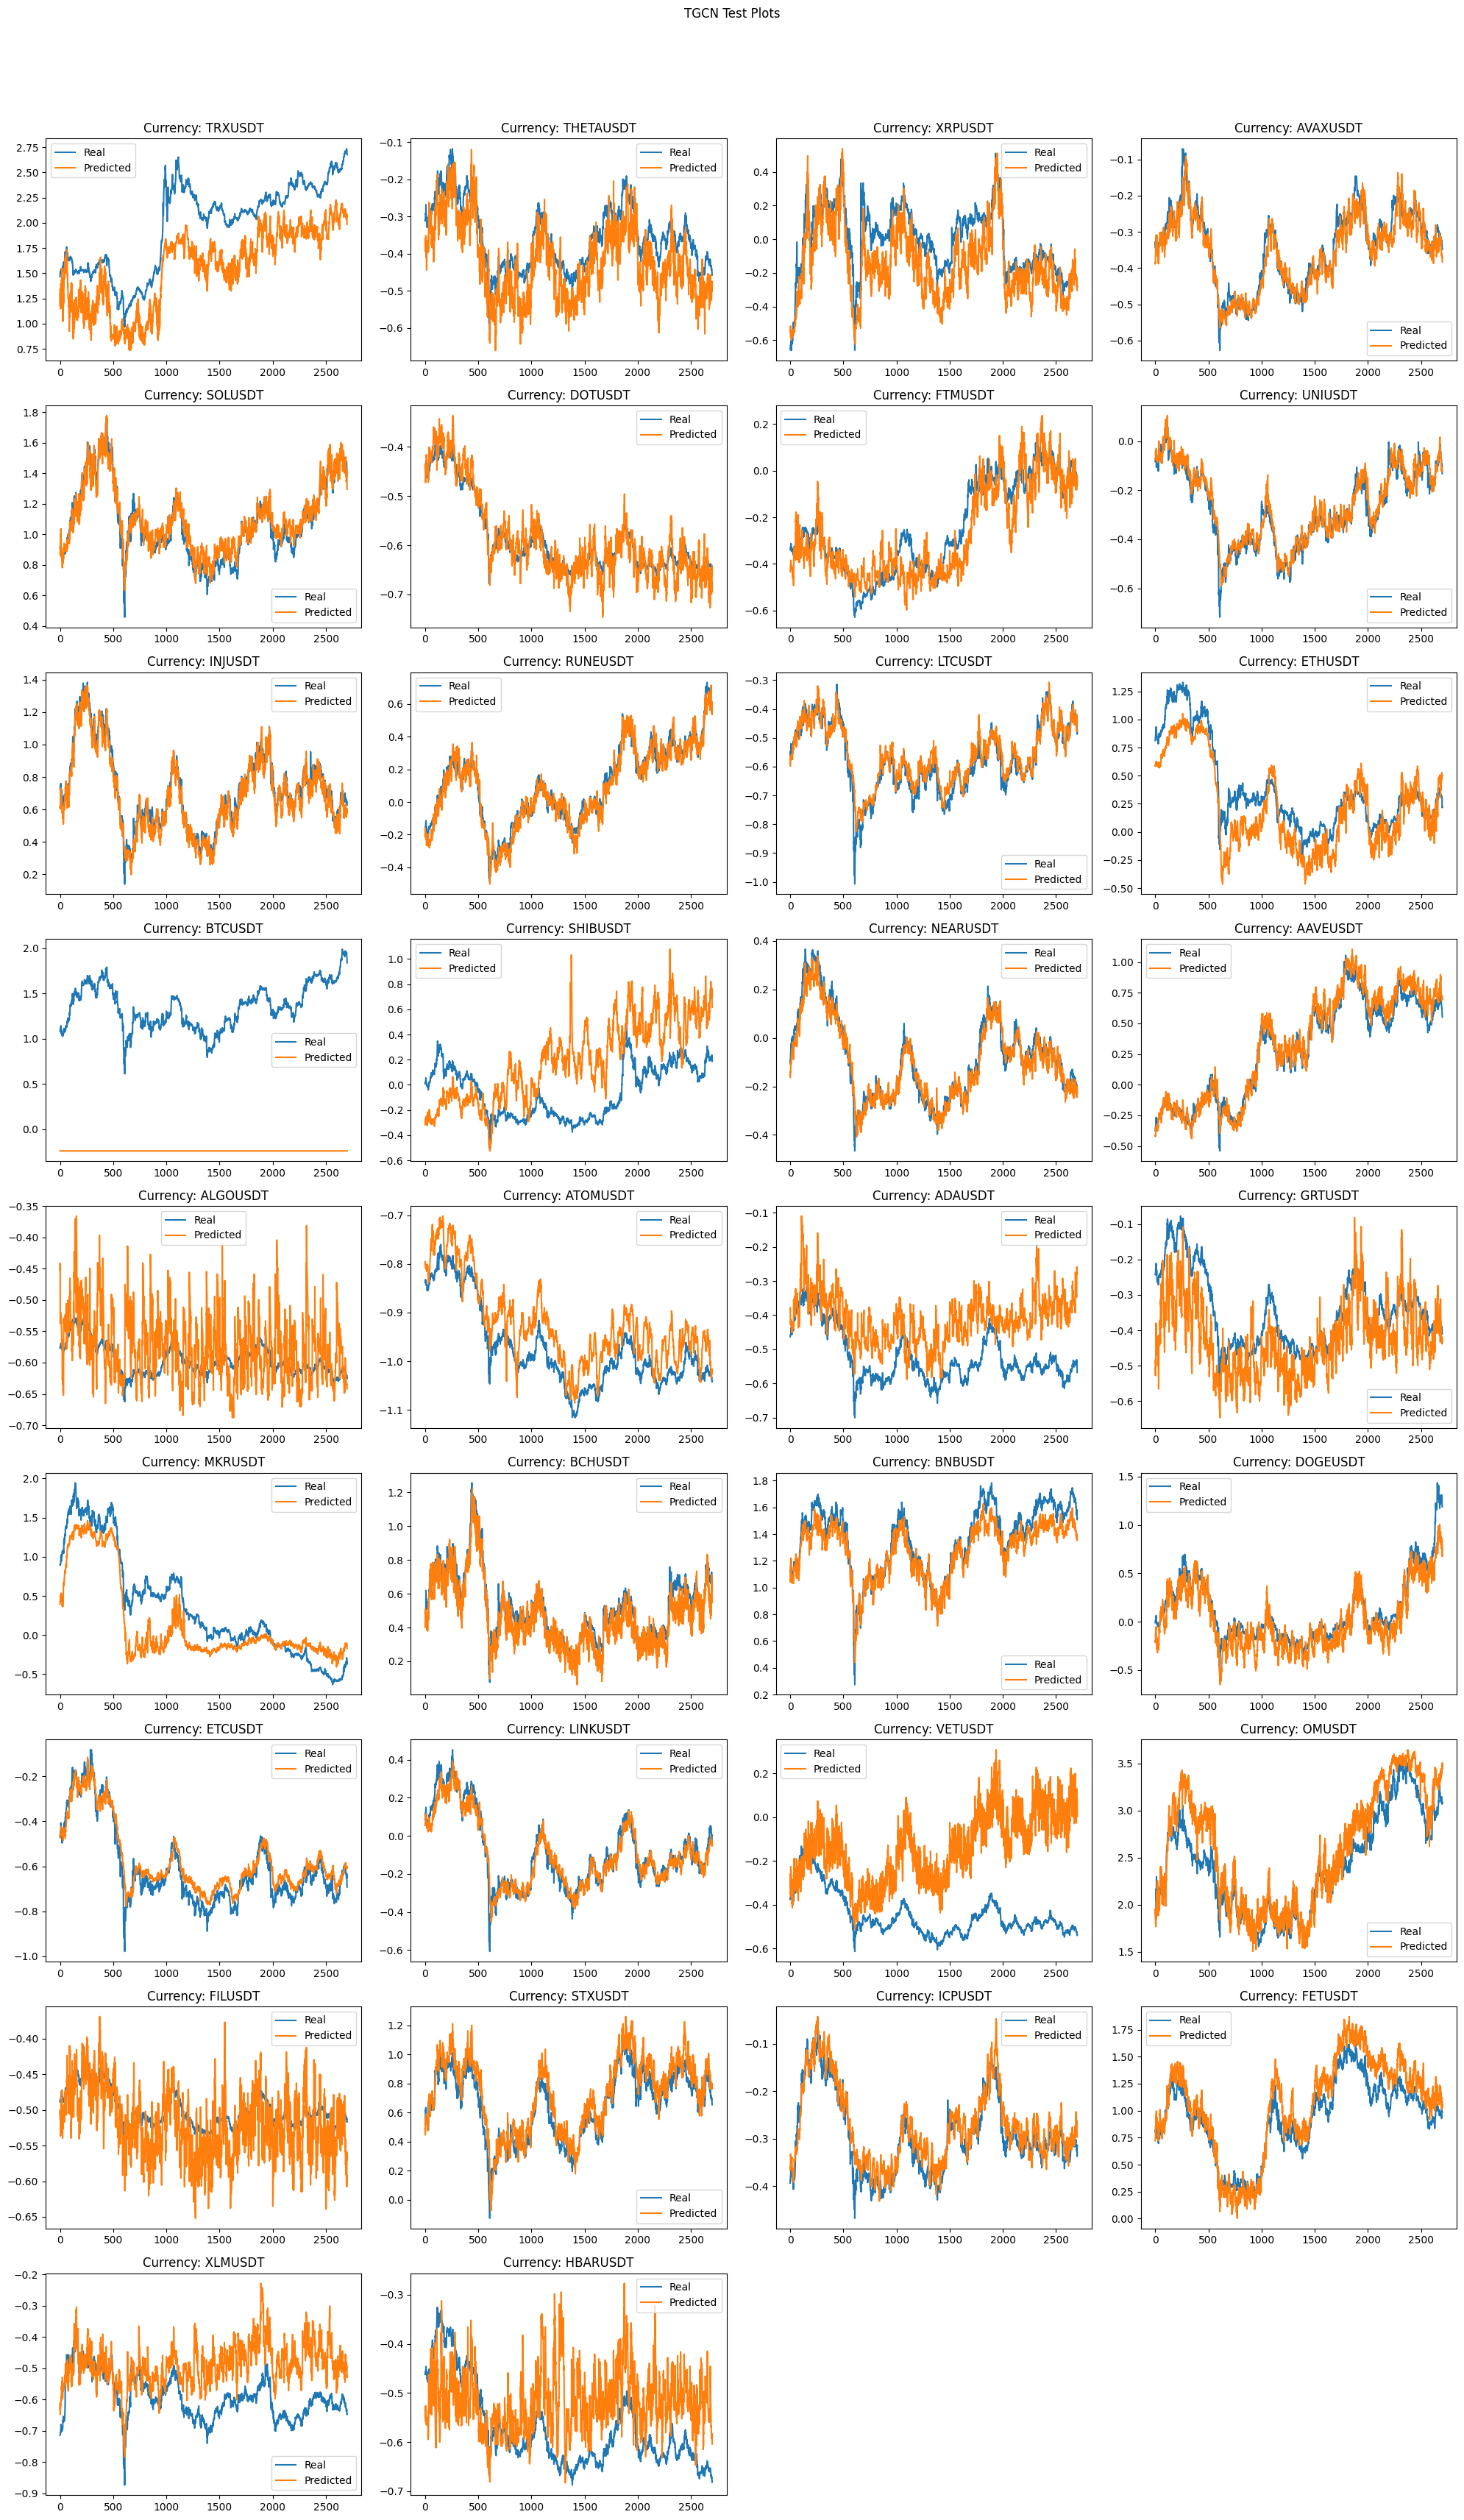

In [23]:
plot_regression_all(tgcn_no_gat_model, next(iter(test_dataloader)), all_data, "TGCN Test Plots")

## A3TCGN Model Results (Without GAT)

In [ ]:
# Train Results (skip as it takes a minute)
mse, rmse, mae, mre = get_regression_error(a3tgcn_no_gat_model, train_dataloader)
print(f"Train MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

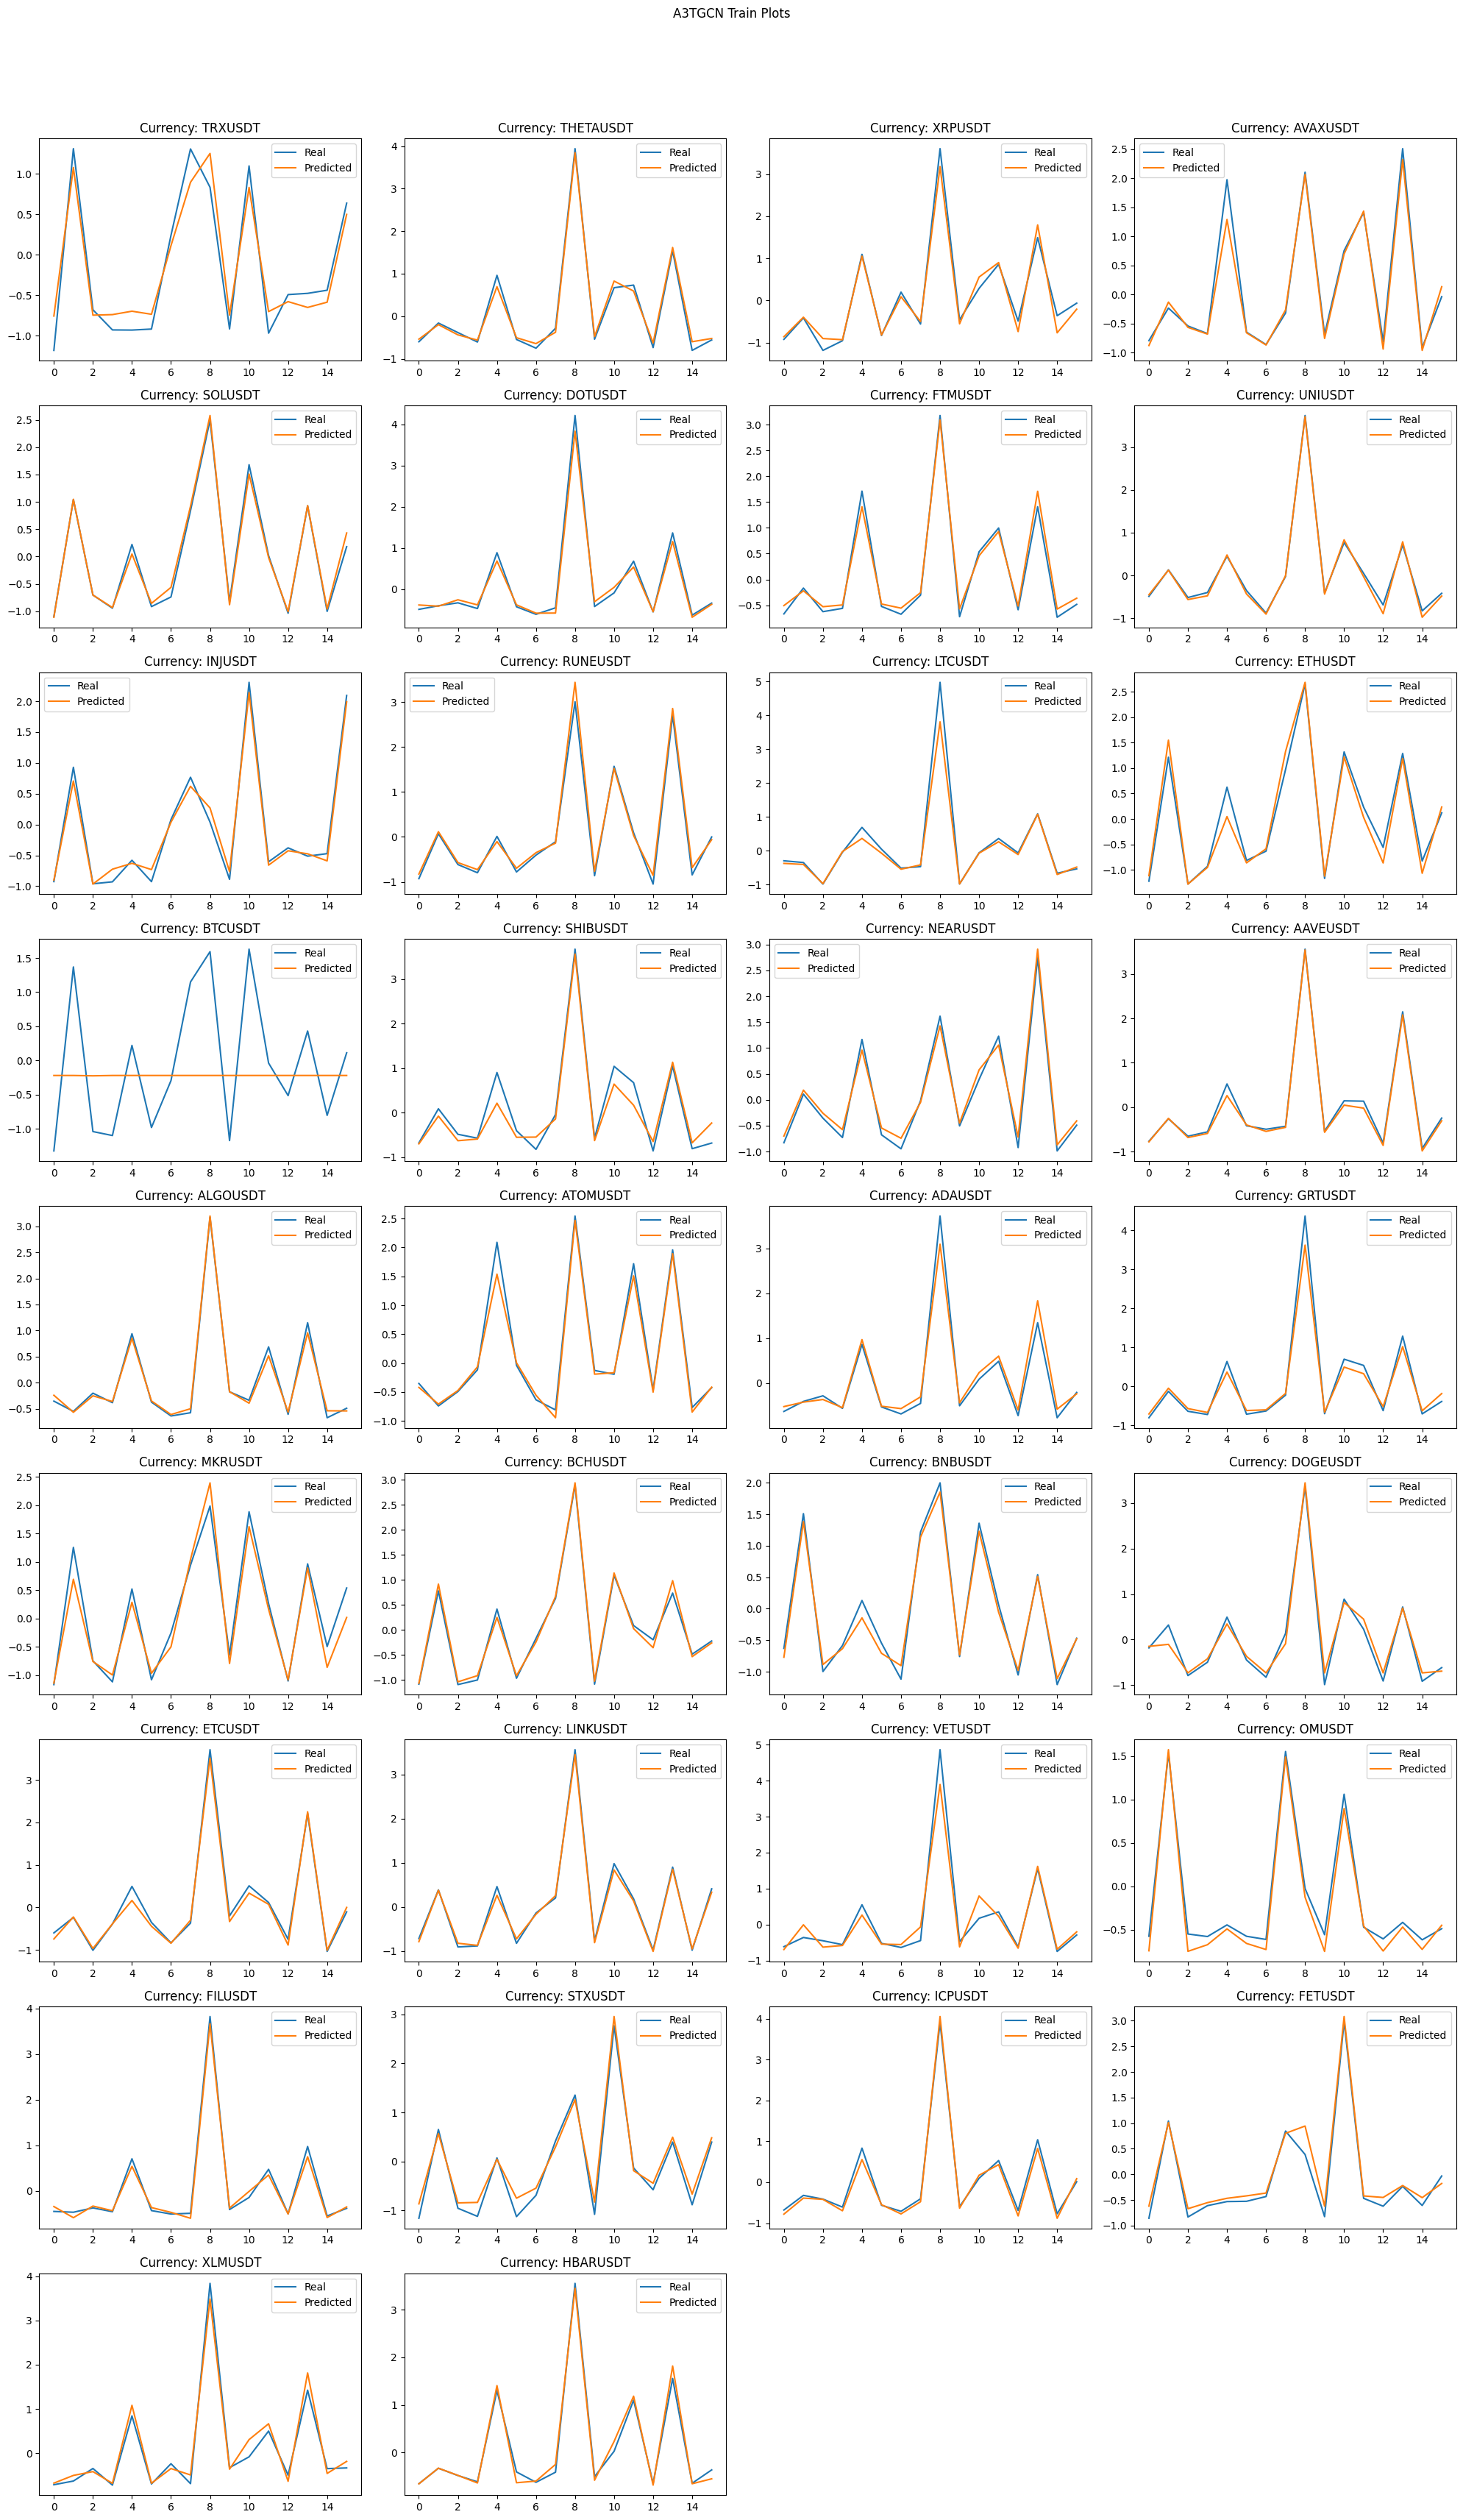

In [33]:
plot_regression_all(a3tgcn_no_gat_model, next(iter(train_dataloader)), all_data, "A3TGCN Train Plots")

In [34]:
# Test Results
mse, rmse, mae, mre = get_regression_error(a3tgcn_no_gat_model, test_dataloader)
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

Test MSE: 0.1379, RMSE: 0.3713, MAE: 0.1975, MRE: 0.3145


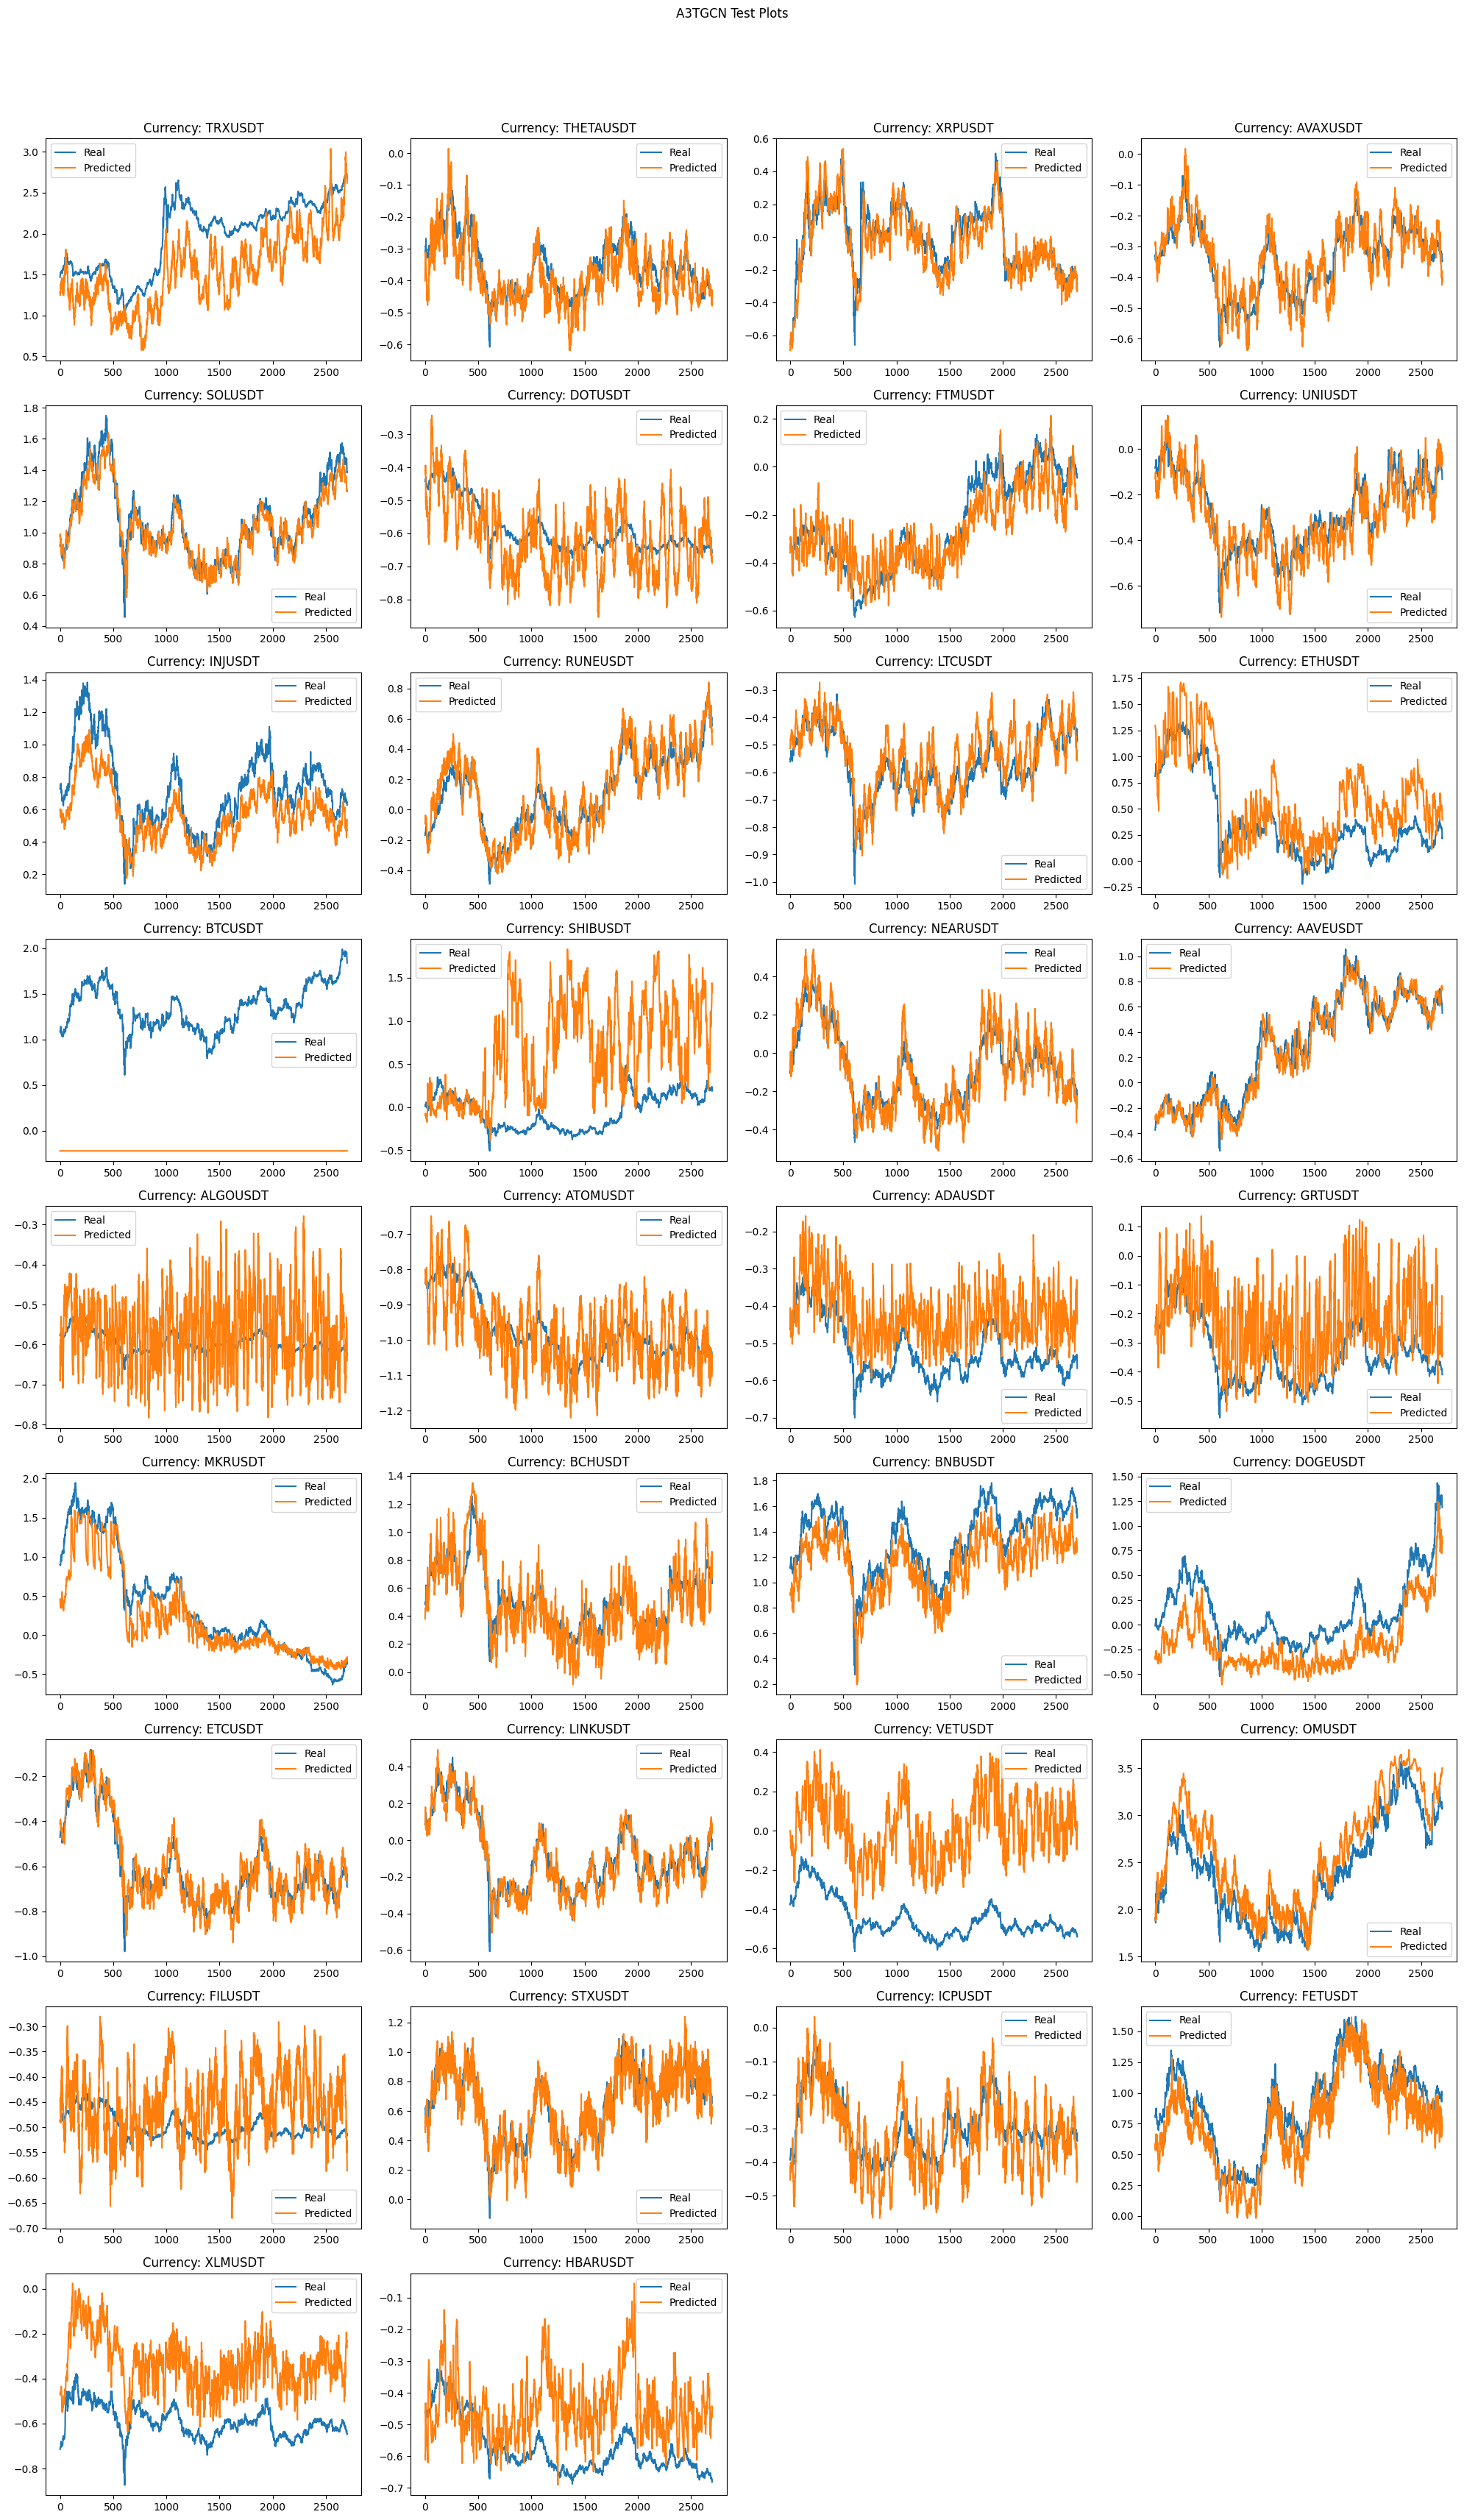

In [35]:
plot_regression_all(a3tgcn_no_gat_model, next(iter(test_dataloader)), all_data, "A3TGCN Test Plots")

## DCGNN Results (No GAT)

In [ ]:
# Train Results (skip as it takes a minute)
mse, rmse, mae, mre = get_regression_error(dcgnn_no_gat_model, train_dataloader)
print(f"Train MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

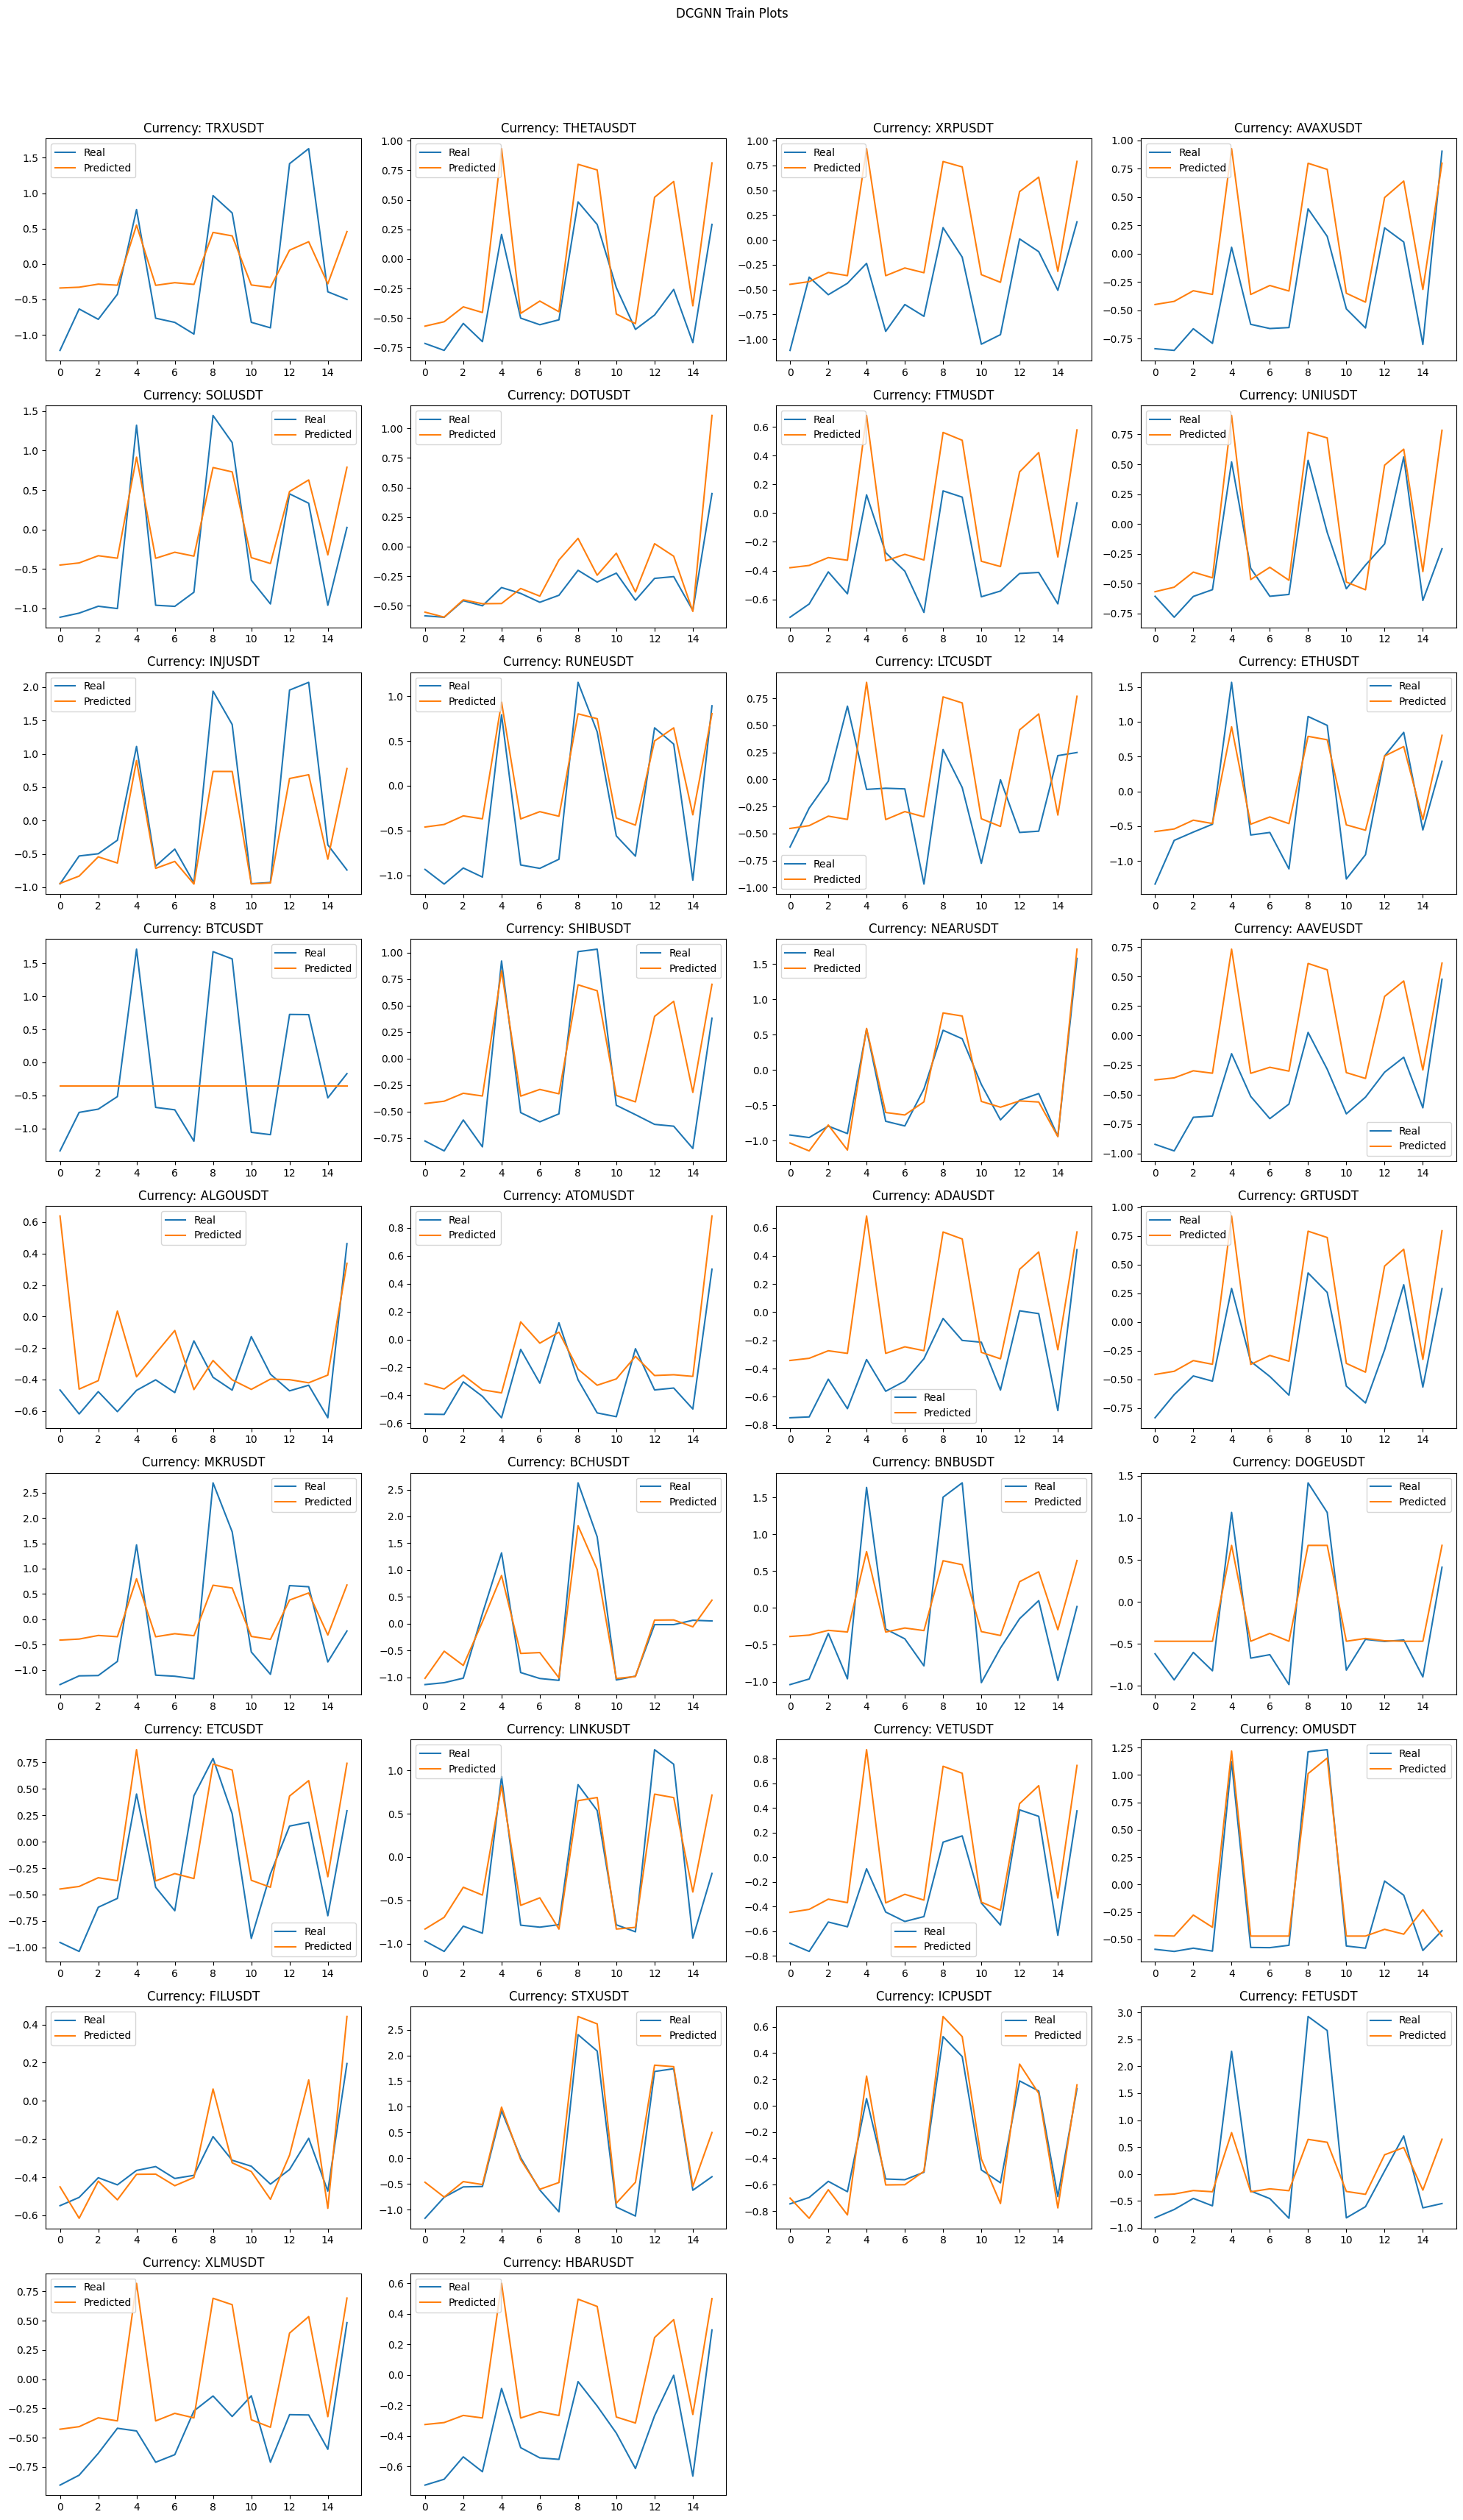

In [38]:
plot_regression_all(dcgnn_no_gat_model, next(iter(train_dataloader)), all_data, "DCGNN Train Plots")

In [39]:
# Test Results
mse, rmse, mae, mre = get_regression_error(dcgnn_no_gat_model, test_dataloader)
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

Test MSE: 0.6760, RMSE: 0.8222, MAE: 0.6696, MRE: 1.0660


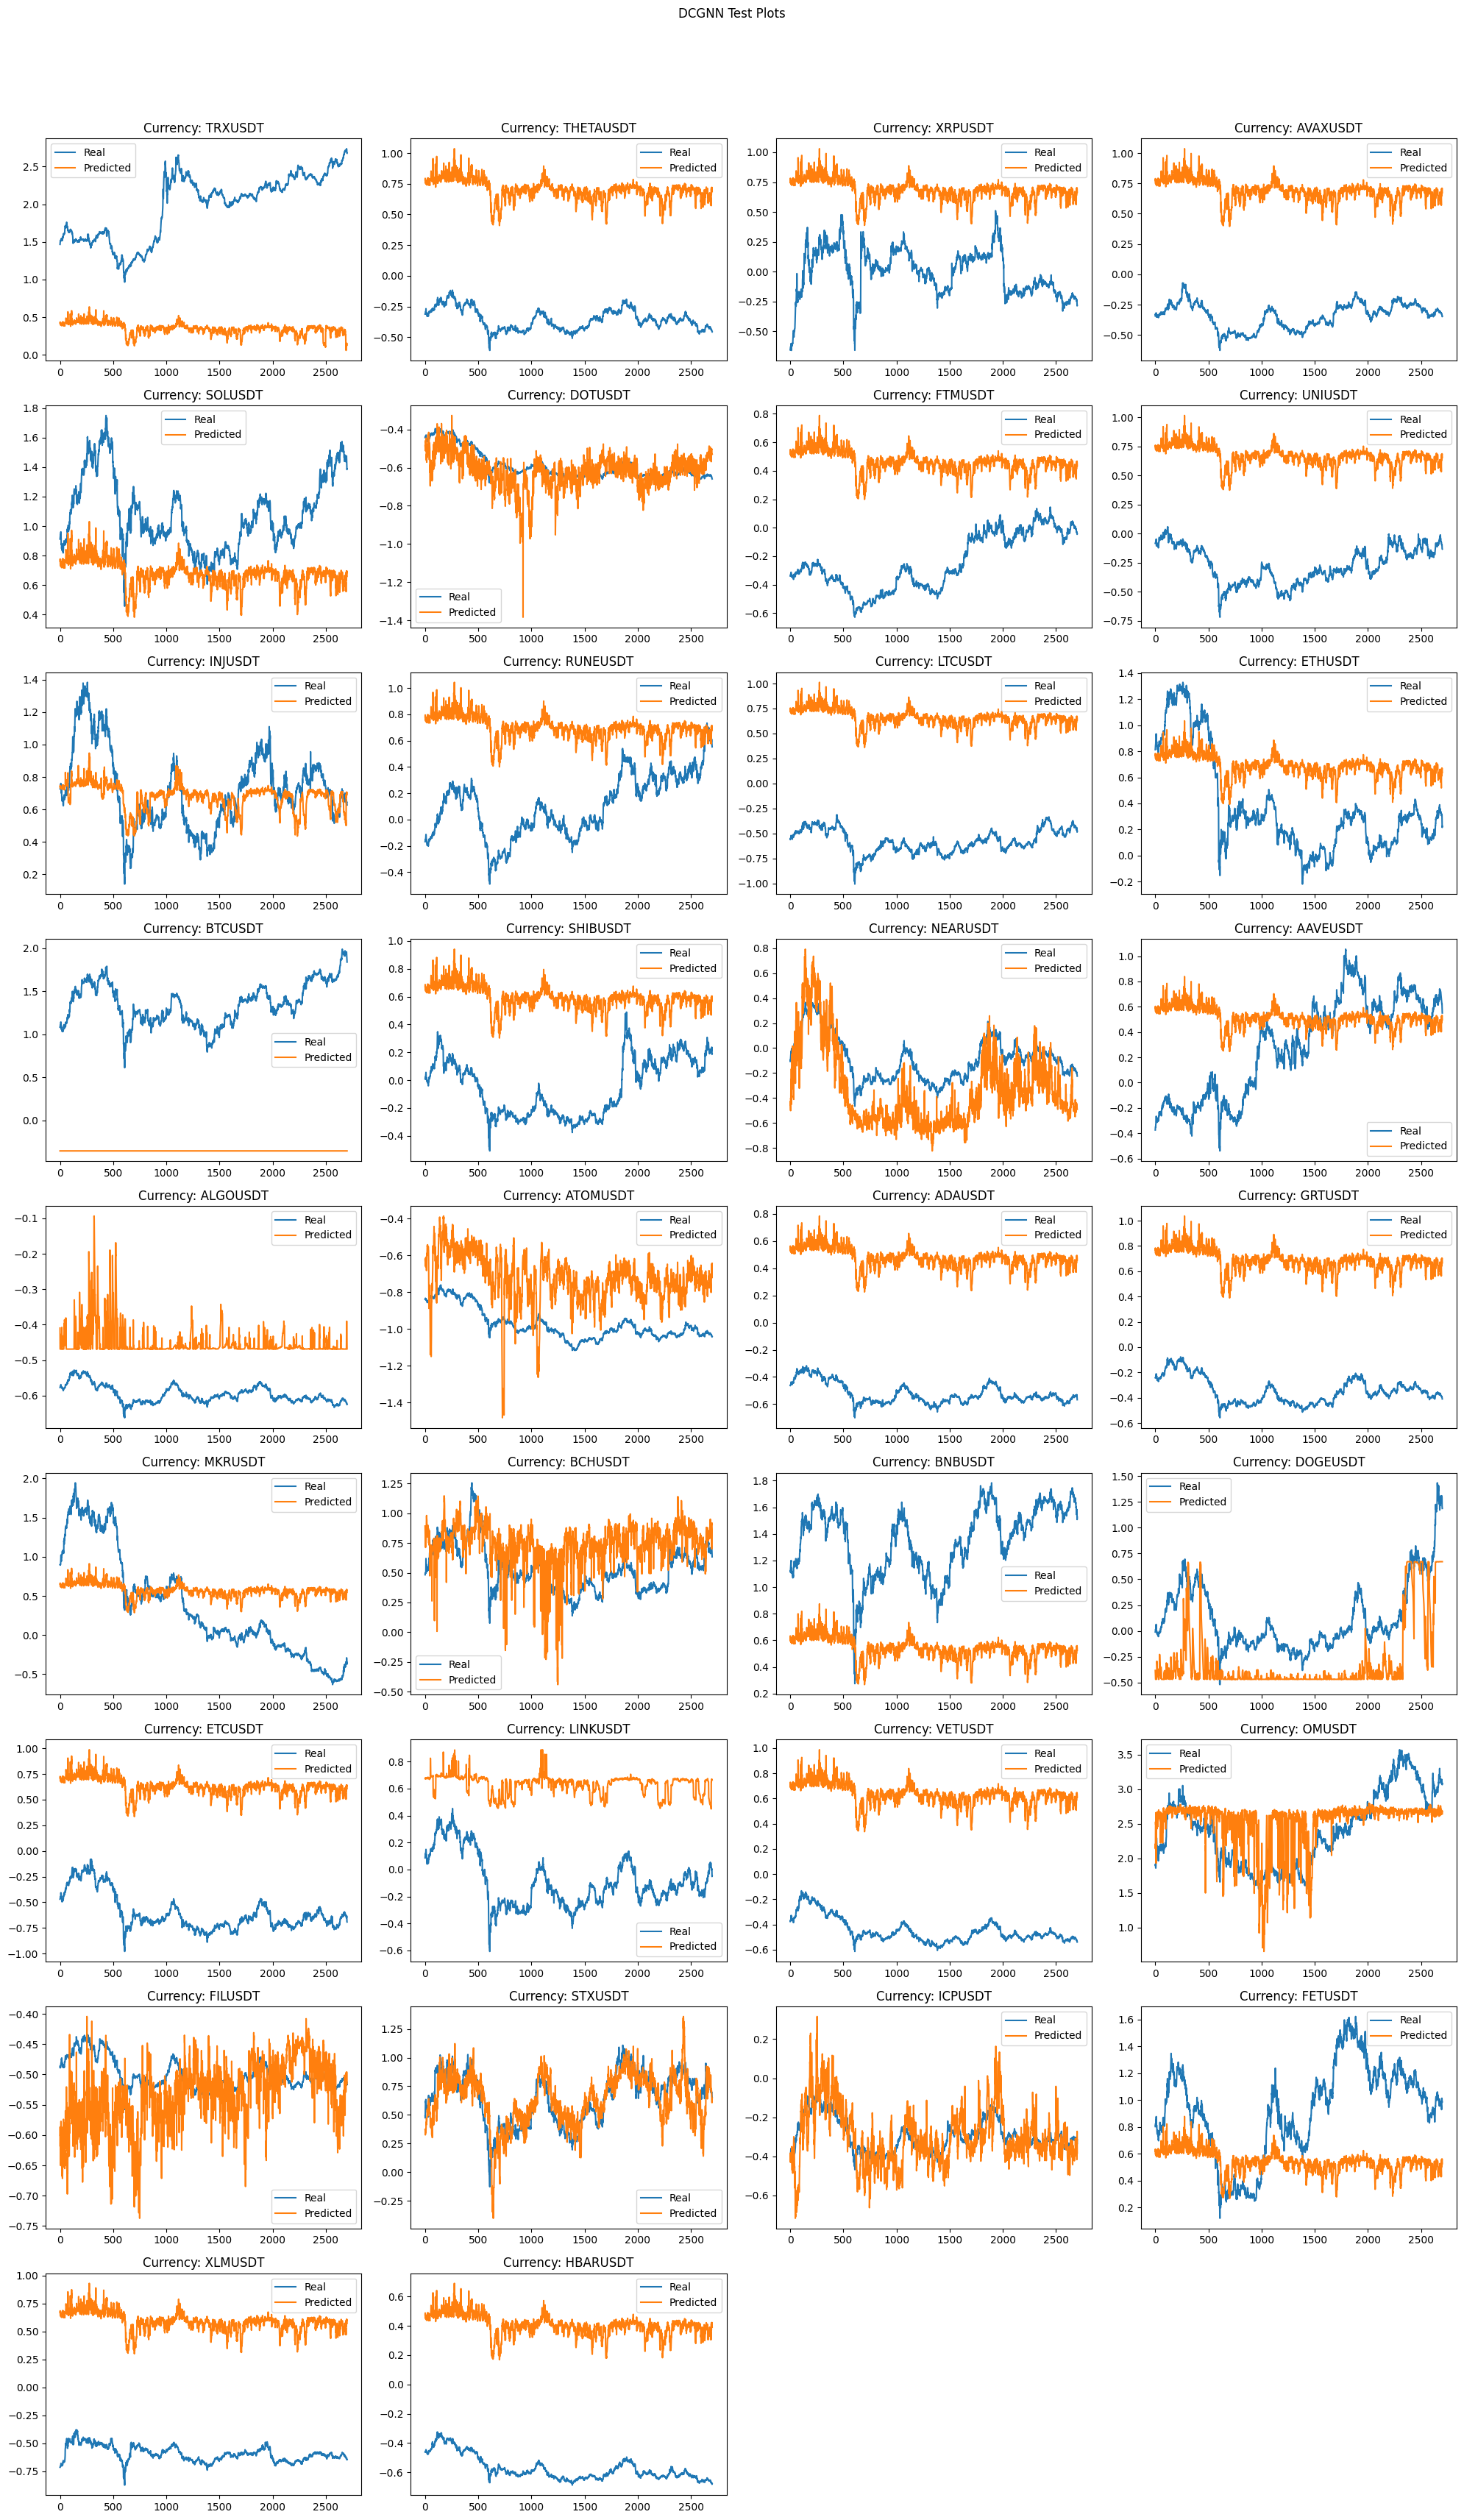

In [40]:
plot_regression_all(dcgnn_no_gat_model, next(iter(test_dataloader)), all_data, "DCGNN Test Plots")